In [90]:
from mhadatareader import MhaDataReader
from classes import ParticipantsData, Scan, ProficiencyLabel, FoldSplit
import utils as ut
import tensorflow as tf
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import random
from tensorflow.keras.utils import plot_model
from sklearn.metrics import recall_score, confusion_matrix, plot_confusion_matrix

import os 

In [35]:
DIR_NAME = './data'
MODEL_NAME = 'best_model.tf'
LOG_DIR = './logs'

In [36]:
def save_model(model, fold):
    model.save(f'./best_model_{fold}.tf')

In [37]:
novices_all, intermed_all, experts_all = ut.load_data(DIR_NAME)
prepared = ut.prepare_data(novices_all, intermed_all, experts_all, incl_extra=False)
slice_window = 70
print(slice_window)

70


In [43]:
folds_stats = []
models_train_hist = dict()

# hyper-parameters #
kernel_size = 5
filters = 32
epochs = 300
batch_size = 16
dropout_rate = 0.3
learning_rate = 0.0001

CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2,
        patience=10, 
        min_lr=0.000001),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=40,
        verbose=1,
    )
]
optimizer = keras.optimizers.Adam(
#     learning_rate=learning_rate,
)
iterations = list(it.permutations([i for i in range(len(prepared[ut.Scan.ALL]))]))
regularizer = keras.regularizers.l1_l2(0.03)

In [67]:
def build_model(input_shape, num_classes, regularizer):
    input_layer = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=10, padding="same", 
                                kernel_regularizer=regularizer,
                                activation='relu')(input_layer)
#     conv1 = keras.layers.Conv1D(filters=128, kernel_size=kernel_size, padding="same", 
#                                 kernel_regularizer=regularizer,
#                                 activation='relu')(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Dropout(0.1)(conv1)
    
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=8, 
                                padding="same", kernel_regularizer=regularizer,
                                activation='relu')(conv1)
#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=kernel_size, 
#                                 padding="same", kernel_regularizer=regularizer,
#                                 activation='relu')(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Dropout(0.2)(conv2)

#     conv3 = keras.layers.Conv1D(filters=32, kernel_size=5, 
#                                 padding="same", kernel_regularizer=regularizer,
#                                 activation='relu')(conv2)
#     conv3 = keras.layers.Conv1D(filters=32, kernel_size=kernel_size, 
#                                 padding="same", kernel_regularizer=regularizer,
#                                 activation='relu')(conv3)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.Dropout(0.3)(conv3)
    
    conv3 = keras.layers.Conv1D(filters=16, kernel_size=5, 
                                padding="same", kernel_regularizer=regularizer,
                                activation='relu')(conv2)
#     conv3 = keras.layers.Conv1D(filters=16, kernel_size=kernel_size, 
#                                 padding="same", kernel_regularizer=regularizer,
#                                 activation='relu')(conv3)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Dropout(0.3)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(gap)
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [48]:
novices_all, intermed_all, experts_all = prepared[ut.Scan.ALL]
folds_all = ut.form_folds(novices_all, intermed_all, experts_all)

In [77]:
model = build_model(
        x_train.shape[1:], 
        len(ProficiencyLabel),
        regularizer=regularizer
    )
plot_model(model)
model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 16, 63)]          0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16, 128)           80768     
_________________________________________________________________
batch_normalization_125 (Bat (None, 16, 128)           512       
_________________________________________________________________
dropout_105 (Dropout)        (None, 16, 128)           0         
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16, 64)            65600     
_________________________________________________________________
batch_normalization_126 (Bat (None, 16, 64)            256       
_________________________________________________________________
dropout_106 (Dropout)        (None, 16, 64)            0  

In [70]:

for i in range(len(iterations)):
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_train, y_train = train
    x_val, y_val = valid
    x_test, y_test = test
    
    print(f'Running fold {i}')
    
    model = build_model(
        x_train.shape[1:], 
        len(ProficiencyLabel), 
        regularizer=regularizer
    )
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
#     plot_model(model, to_file='model.png')
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=CALLBACKS,
        validation_data=(x_val, y_val),
        verbose=1,
    )
    
    models_train_hist[i] = history.history

#     test_loss, test_acc = model.evaluate(x_test, y_test)
#     print('Test accuracy', test_acc)
#     print('Test loss', test_loss)
    
    save_model(model, i)

#     folds_stats.append((test_loss, test_acc))

Running fold 0
Epoch 1/300
1336/1336 [==============================] - 10s 7ms/step - loss: 138.1142 - sparse_categorical_accuracy: 0.3612 - val_loss: 132.4357 - val_sparse_categorical_accuracy: 0.4208
Epoch 2/300
1336/1336 [==============================] - 9s 7ms/step - loss: 130.7521 - sparse_categorical_accuracy: 0.3542 - val_loss: 126.7803 - val_sparse_categorical_accuracy: 0.4381
Epoch 3/300
1336/1336 [==============================] - 9s 7ms/step - loss: 125.3229 - sparse_categorical_accuracy: 0.3672 - val_loss: 121.5616 - val_sparse_categorical_accuracy: 0.4592
Epoch 4/300
1336/1336 [==============================] - 10s 7ms/step - loss: 120.2131 - sparse_categorical_accuracy: 0.3991 - val_loss: 116.5241 - val_sparse_categorical_accuracy: 0.4778
Epoch 5/300
1336/1336 [==============================] - 10s 7ms/step - loss: 115.2587 - sparse_categorical_accuracy: 0.4166 - val_loss: 111.6576 - val_sparse_categorical_accuracy: 0.4849
Epoch 6/300
1336/1336 [========================

Epoch 45/300
1336/1336 [==============================] - 9s 7ms/step - loss: 12.5271 - sparse_categorical_accuracy: 0.7704 - val_loss: 12.1133 - val_sparse_categorical_accuracy: 0.6768
Epoch 46/300
1336/1336 [==============================] - 9s 7ms/step - loss: 11.8737 - sparse_categorical_accuracy: 0.7726 - val_loss: 11.4998 - val_sparse_categorical_accuracy: 0.6927
Epoch 47/300
1336/1336 [==============================] - 9s 7ms/step - loss: 11.2592 - sparse_categorical_accuracy: 0.7777 - val_loss: 10.9274 - val_sparse_categorical_accuracy: 0.6842
Epoch 48/300
1336/1336 [==============================] - 9s 7ms/step - loss: 10.6800 - sparse_categorical_accuracy: 0.7937 - val_loss: 10.3880 - val_sparse_categorical_accuracy: 0.7073
Epoch 49/300
1336/1336 [==============================] - 9s 7ms/step - loss: 10.1574 - sparse_categorical_accuracy: 0.7902 - val_loss: 9.9017 - val_sparse_categorical_accuracy: 0.6969
Epoch 50/300
1336/1336 [==============================] - 9s 7ms/step -

1336/1336 [==============================] - 9s 7ms/step - loss: 1.0839 - sparse_categorical_accuracy: 0.8900 - val_loss: 1.0309 - val_sparse_categorical_accuracy: 0.8933
Epoch 134/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.0684 - sparse_categorical_accuracy: 0.8877 - val_loss: 1.0842 - val_sparse_categorical_accuracy: 0.8551
Epoch 135/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.0504 - sparse_categorical_accuracy: 0.8919 - val_loss: 1.0362 - val_sparse_categorical_accuracy: 0.8754
Epoch 136/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.0386 - sparse_categorical_accuracy: 0.8913 - val_loss: 1.0438 - val_sparse_categorical_accuracy: 0.8647
Epoch 137/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.0236 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.9725 - val_sparse_categorical_accuracy: 0.9033
Epoch 138/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.0060 - s

1336/1336 [==============================] - 9s 7ms/step - loss: 0.5826 - sparse_categorical_accuracy: 0.9034 - val_loss: 0.5888 - val_sparse_categorical_accuracy: 0.9298
Epoch 222/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5690 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.5843 - val_sparse_categorical_accuracy: 0.9210
Epoch 223/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5731 - sparse_categorical_accuracy: 0.9073 - val_loss: 0.6000 - val_sparse_categorical_accuracy: 0.9292
Epoch 224/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5753 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.5964 - val_sparse_categorical_accuracy: 0.8969
Epoch 225/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5755 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.6181 - val_sparse_categorical_accuracy: 0.9167
Epoch 226/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5659 - s

Epoch 9/300
1336/1336 [==============================] - 9s 6ms/step - loss: 93.9707 - sparse_categorical_accuracy: 0.5640 - val_loss: 90.7860 - val_sparse_categorical_accuracy: 0.4928
Epoch 10/300
1336/1336 [==============================] - 9s 6ms/step - loss: 89.4733 - sparse_categorical_accuracy: 0.5613 - val_loss: 86.3875 - val_sparse_categorical_accuracy: 0.4945
Epoch 11/300
1336/1336 [==============================] - 8s 6ms/step - loss: 85.1045 - sparse_categorical_accuracy: 0.5662 - val_loss: 82.1300 - val_sparse_categorical_accuracy: 0.4951
Epoch 12/300
1336/1336 [==============================] - 9s 7ms/step - loss: 80.8836 - sparse_categorical_accuracy: 0.5630 - val_loss: 78.0112 - val_sparse_categorical_accuracy: 0.4965
Epoch 13/300
1336/1336 [==============================] - 9s 6ms/step - loss: 76.7961 - sparse_categorical_accuracy: 0.5692 - val_loss: 74.0243 - val_sparse_categorical_accuracy: 0.4990
Epoch 14/300
1336/1336 [==============================] - 9s 6ms/step -

1336/1336 [==============================] - 9s 6ms/step - loss: 2.0863 - sparse_categorical_accuracy: 0.8681 - val_loss: 2.6510 - val_sparse_categorical_accuracy: 0.6222
Epoch 98/300
1336/1336 [==============================] - 9s 7ms/step - loss: 2.0518 - sparse_categorical_accuracy: 0.8647 - val_loss: 2.5389 - val_sparse_categorical_accuracy: 0.6358
Epoch 99/300
1336/1336 [==============================] - 9s 6ms/step - loss: 2.0005 - sparse_categorical_accuracy: 0.8692 - val_loss: 2.5083 - val_sparse_categorical_accuracy: 0.6320
Epoch 100/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.9661 - sparse_categorical_accuracy: 0.8718 - val_loss: 2.5087 - val_sparse_categorical_accuracy: 0.6229
Epoch 101/300
1336/1336 [==============================] - 9s 6ms/step - loss: 1.9339 - sparse_categorical_accuracy: 0.8655 - val_loss: 2.4337 - val_sparse_categorical_accuracy: 0.6293
Epoch 102/300
1336/1336 [==============================] - 9s 7ms/step - loss: 1.8897 - spa

1336/1336 [==============================] - 9s 6ms/step - loss: 0.7175 - sparse_categorical_accuracy: 0.9002 - val_loss: 1.0246 - val_sparse_categorical_accuracy: 0.7381
Epoch 186/300
1336/1336 [==============================] - 9s 6ms/step - loss: 0.7128 - sparse_categorical_accuracy: 0.9007 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.7648
Epoch 187/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.7114 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.7617
Epoch 188/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.8982 - val_loss: 0.9477 - val_sparse_categorical_accuracy: 0.7613
Epoch 189/300
1336/1336 [==============================] - 9s 6ms/step - loss: 0.7006 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.9600 - val_sparse_categorical_accuracy: 0.7646
Epoch 190/300
1336/1336 [==============================] - 9s 6ms/step - loss: 0.6953 - s

1336/1336 [==============================] - 9s 7ms/step - loss: 0.5076 - sparse_categorical_accuracy: 0.9062 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.8321
Epoch 274/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5155 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.8514
Epoch 275/300
1336/1336 [==============================] - 9s 6ms/step - loss: 0.5039 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.8839
Epoch 276/300
1336/1336 [==============================] - 9s 7ms/step - loss: 0.5012 - sparse_categorical_accuracy: 0.9089 - val_loss: 0.6511 - val_sparse_categorical_accuracy: 0.8460
Epoch 277/300
1336/1336 [==============================] - 9s 6ms/step - loss: 0.5051 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.8409
Epoch 278/300
1336/1336 [==============================] - 9s 6ms/step - loss: 0.5058 - s

Epoch 17/300
1707/1707 [==============================] - 10s 6ms/step - loss: 49.2489 - sparse_categorical_accuracy: 0.6301 - val_loss: 46.6099 - val_sparse_categorical_accuracy: 0.5761
Epoch 18/300
1707/1707 [==============================] - 10s 6ms/step - loss: 45.6752 - sparse_categorical_accuracy: 0.6435 - val_loss: 43.1942 - val_sparse_categorical_accuracy: 0.5753
Epoch 19/300
1707/1707 [==============================] - 10s 6ms/step - loss: 42.3102 - sparse_categorical_accuracy: 0.6395 - val_loss: 39.9800 - val_sparse_categorical_accuracy: 0.5755
Epoch 20/300
1707/1707 [==============================] - 10s 6ms/step - loss: 39.1260 - sparse_categorical_accuracy: 0.6600 - val_loss: 36.9540 - val_sparse_categorical_accuracy: 0.5761
Epoch 21/300
1707/1707 [==============================] - 10s 6ms/step - loss: 36.1504 - sparse_categorical_accuracy: 0.6638 - val_loss: 34.1340 - val_sparse_categorical_accuracy: 0.5660
Epoch 22/300
1707/1707 [==============================] - 10s 6ms

1707/1707 [==============================] - 10s 6ms/step - loss: 2.9823 - sparse_categorical_accuracy: 0.8560 - val_loss: 3.1477 - val_sparse_categorical_accuracy: 0.7399
Epoch 62/300
1707/1707 [==============================] - 10s 6ms/step - loss: 2.8627 - sparse_categorical_accuracy: 0.8598 - val_loss: 3.0064 - val_sparse_categorical_accuracy: 0.7566
Epoch 63/300
1707/1707 [==============================] - 10s 6ms/step - loss: 2.7545 - sparse_categorical_accuracy: 0.8581 - val_loss: 2.8972 - val_sparse_categorical_accuracy: 0.7587
Epoch 64/300
1707/1707 [==============================] - 10s 6ms/step - loss: 2.6506 - sparse_categorical_accuracy: 0.8579 - val_loss: 2.8337 - val_sparse_categorical_accuracy: 0.7194
Epoch 65/300
1707/1707 [==============================] - 11s 6ms/step - loss: 2.5491 - sparse_categorical_accuracy: 0.8604 - val_loss: 2.7002 - val_sparse_categorical_accuracy: 0.7697
Epoch 66/300
1707/1707 [==============================] - 11s 6ms/step - loss: 2.4516 - 

1707/1707 [==============================] - 10s 6ms/step - loss: 0.6007 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.8728
Epoch 150/300
1707/1707 [==============================] - 10s 6ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.7049 - val_sparse_categorical_accuracy: 0.8663
Epoch 151/300
1707/1707 [==============================] - 11s 7ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.7172 - val_sparse_categorical_accuracy: 0.8362
Epoch 152/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.5842 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.7240 - val_sparse_categorical_accuracy: 0.8376
Epoch 153/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.5837 - sparse_categorical_accuracy: 0.8943 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.8801
Epoch 154/300
1707/1707 [==============================] - 10s 6ms/step - loss: 0.58

1707/1707 [==============================] - 11s 6ms/step - loss: 0.4556 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.5747 - val_sparse_categorical_accuracy: 0.8579
Epoch 238/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4661 - sparse_categorical_accuracy: 0.8900 - val_loss: 0.5912 - val_sparse_categorical_accuracy: 0.8456
Epoch 239/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4630 - sparse_categorical_accuracy: 0.8909 - val_loss: 0.5477 - val_sparse_categorical_accuracy: 0.8688
Epoch 240/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4602 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.5691 - val_sparse_categorical_accuracy: 0.8495
Epoch 241/300
1707/1707 [==============================] - 10s 6ms/step - loss: 0.4603 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.6033 - val_sparse_categorical_accuracy: 0.8133
Epoch 242/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.46

1707/1707 [==============================] - 11s 6ms/step - loss: 25.9290 - sparse_categorical_accuracy: 0.6776 - val_loss: 24.4766 - val_sparse_categorical_accuracy: 0.5217
Epoch 25/300
1707/1707 [==============================] - 11s 6ms/step - loss: 23.8003 - sparse_categorical_accuracy: 0.6853 - val_loss: 22.4802 - val_sparse_categorical_accuracy: 0.5242
Epoch 26/300
1707/1707 [==============================] - 11s 6ms/step - loss: 21.8389 - sparse_categorical_accuracy: 0.6986 - val_loss: 20.6533 - val_sparse_categorical_accuracy: 0.5265
Epoch 27/300
1707/1707 [==============================] - 11s 6ms/step - loss: 20.0469 - sparse_categorical_accuracy: 0.6985 - val_loss: 18.9841 - val_sparse_categorical_accuracy: 0.5283
Epoch 28/300
1707/1707 [==============================] - 11s 6ms/step - loss: 18.4105 - sparse_categorical_accuracy: 0.7054 - val_loss: 17.4585 - val_sparse_categorical_accuracy: 0.5307
Epoch 29/300
1707/1707 [==============================] - 11s 6ms/step - loss:

1707/1707 [==============================] - 11s 6ms/step - loss: 0.7494 - sparse_categorical_accuracy: 0.8922 - val_loss: 1.0620 - val_sparse_categorical_accuracy: 0.7531
Epoch 113/300
1707/1707 [==============================] - 10s 6ms/step - loss: 0.7443 - sparse_categorical_accuracy: 0.8909 - val_loss: 1.0250 - val_sparse_categorical_accuracy: 0.7581
Epoch 114/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.7452 - sparse_categorical_accuracy: 0.8861 - val_loss: 1.0080 - val_sparse_categorical_accuracy: 0.8210
Epoch 115/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.7291 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.9695 - val_sparse_categorical_accuracy: 0.8374
Epoch 116/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.7193 - sparse_categorical_accuracy: 0.8934 - val_loss: 0.9417 - val_sparse_categorical_accuracy: 0.8189
Epoch 117/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.71

1707/1707 [==============================] - 11s 6ms/step - loss: 0.4744 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.7087 - val_sparse_categorical_accuracy: 0.8328
Epoch 201/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4724 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.7237 - val_sparse_categorical_accuracy: 0.8029
Epoch 202/300
1707/1707 [==============================] - 10s 6ms/step - loss: 0.4732 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.8190
Epoch 203/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4668 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.7263 - val_sparse_categorical_accuracy: 0.8240
Epoch 204/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4718 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.7078 - val_sparse_categorical_accuracy: 0.8224
Epoch 205/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.46

1707/1707 [==============================] - 11s 6ms/step - loss: 0.4078 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.6317 - val_sparse_categorical_accuracy: 0.8189
Epoch 289/300
1707/1707 [==============================] - 11s 7ms/step - loss: 0.4230 - sparse_categorical_accuracy: 0.8927 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.8179
Epoch 290/300
1707/1707 [==============================] - 11s 7ms/step - loss: 0.4095 - sparse_categorical_accuracy: 0.8987 - val_loss: 0.6462 - val_sparse_categorical_accuracy: 0.7955
Epoch 291/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4094 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.6305 - val_sparse_categorical_accuracy: 0.8227
Epoch 292/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.4071 - sparse_categorical_accuracy: 0.9001 - val_loss: 0.6224 - val_sparse_categorical_accuracy: 0.8384
Epoch 293/300
1707/1707 [==============================] - 11s 6ms/step - loss: 0.41

1573/1573 [==============================] - 10s 6ms/step - loss: 2.9615 - sparse_categorical_accuracy: 0.8320 - val_loss: 3.0153 - val_sparse_categorical_accuracy: 0.8128
Epoch 76/300
1573/1573 [==============================] - 10s 6ms/step - loss: 2.8639 - sparse_categorical_accuracy: 0.8404 - val_loss: 2.9079 - val_sparse_categorical_accuracy: 0.7932
Epoch 77/300
1573/1573 [==============================] - 10s 6ms/step - loss: 2.7876 - sparse_categorical_accuracy: 0.8370 - val_loss: 2.8255 - val_sparse_categorical_accuracy: 0.8137
Epoch 78/300
1573/1573 [==============================] - 10s 6ms/step - loss: 2.7036 - sparse_categorical_accuracy: 0.8386 - val_loss: 2.7735 - val_sparse_categorical_accuracy: 0.7840
Epoch 79/300
1573/1573 [==============================] - 10s 6ms/step - loss: 2.6219 - sparse_categorical_accuracy: 0.8381 - val_loss: 2.6614 - val_sparse_categorical_accuracy: 0.8635
Epoch 80/300
1573/1573 [==============================] - 10s 6ms/step - loss: 2.5455 - 

1573/1573 [==============================] - 10s 6ms/step - loss: 0.7087 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.8616 - val_sparse_categorical_accuracy: 0.8899
Epoch 164/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.9642 - val_sparse_categorical_accuracy: 0.7819
Epoch 165/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.7039 - sparse_categorical_accuracy: 0.8982 - val_loss: 0.9829 - val_sparse_categorical_accuracy: 0.7749
Epoch 166/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.7137 - sparse_categorical_accuracy: 0.8902 - val_loss: 0.8911 - val_sparse_categorical_accuracy: 0.8285
Epoch 167/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.8149
Epoch 168/300
1573/1573 [==============================] - 10s 7ms/step - loss: 0.69

1573/1573 [==============================] - 10s 6ms/step - loss: 0.5093 - sparse_categorical_accuracy: 0.9041 - val_loss: 0.7276 - val_sparse_categorical_accuracy: 0.8217
Epoch 252/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.5079 - sparse_categorical_accuracy: 0.9052 - val_loss: 0.6713 - val_sparse_categorical_accuracy: 0.8345
Epoch 253/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.4968 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.6779 - val_sparse_categorical_accuracy: 0.8544
Epoch 254/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.5065 - sparse_categorical_accuracy: 0.9057 - val_loss: 0.6250 - val_sparse_categorical_accuracy: 0.8737
Epoch 255/300
1573/1573 [==============================] - 10s 7ms/step - loss: 0.4996 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.7339 - val_sparse_categorical_accuracy: 0.8183
Epoch 256/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.50

1573/1573 [==============================] - 10s 7ms/step - loss: 13.0463 - sparse_categorical_accuracy: 0.7362 - val_loss: 12.3483 - val_sparse_categorical_accuracy: 0.7935
Epoch 39/300
1573/1573 [==============================] - 10s 7ms/step - loss: 12.2051 - sparse_categorical_accuracy: 0.7347 - val_loss: 11.5478 - val_sparse_categorical_accuracy: 0.8038
Epoch 40/300
1573/1573 [==============================] - 11s 7ms/step - loss: 11.4325 - sparse_categorical_accuracy: 0.7391 - val_loss: 10.8274 - val_sparse_categorical_accuracy: 0.8193
Epoch 41/300
1573/1573 [==============================] - 10s 7ms/step - loss: 10.7104 - sparse_categorical_accuracy: 0.7505 - val_loss: 10.1509 - val_sparse_categorical_accuracy: 0.8103
Epoch 42/300
1573/1573 [==============================] - 11s 7ms/step - loss: 10.0484 - sparse_categorical_accuracy: 0.7560 - val_loss: 9.5335 - val_sparse_categorical_accuracy: 0.8251
Epoch 43/300
1573/1573 [==============================] - 10s 7ms/step - loss: 

1573/1573 [==============================] - 10s 7ms/step - loss: 0.8679 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.8864 - val_sparse_categorical_accuracy: 0.8739
Epoch 127/300
1573/1573 [==============================] - 11s 7ms/step - loss: 0.8548 - sparse_categorical_accuracy: 0.8903 - val_loss: 0.8792 - val_sparse_categorical_accuracy: 0.8682
Epoch 128/300
1573/1573 [==============================] - 10s 7ms/step - loss: 0.8441 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.8731 - val_sparse_categorical_accuracy: 0.8738
Epoch 129/300
1573/1573 [==============================] - 10s 7ms/step - loss: 0.8411 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.8895 - val_sparse_categorical_accuracy: 0.8664
Epoch 130/300
1573/1573 [==============================] - 10s 7ms/step - loss: 0.8345 - sparse_categorical_accuracy: 0.8882 - val_loss: 0.9431 - val_sparse_categorical_accuracy: 0.8484
Epoch 131/300
1573/1573 [==============================] - 11s 7ms/step - loss: 0.82

1573/1573 [==============================] - 11s 7ms/step - loss: 0.5293 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.6661 - val_sparse_categorical_accuracy: 0.8493
Epoch 215/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.5245 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.5627 - val_sparse_categorical_accuracy: 0.8822
Epoch 216/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.5180 - sparse_categorical_accuracy: 0.9037 - val_loss: 0.5661 - val_sparse_categorical_accuracy: 0.8919
Epoch 217/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.5285 - sparse_categorical_accuracy: 0.8986 - val_loss: 0.6030 - val_sparse_categorical_accuracy: 0.8641
Epoch 218/300
1573/1573 [==============================] - 10s 6ms/step - loss: 0.5206 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.5799 - val_sparse_categorical_accuracy: 0.8810
Epoch 219/300
1573/1573 [==============================] - 10s 7ms/step - loss: 0.51

In [79]:
models = []
m_losses = []
m_accs = []

for i in range(6):
    models.append(keras.models.load_model( f'./best_model_{i}.tf'))
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_test, y_test = test
                  
    mloss, macc = models[i].evaluate(x_test, y_test)
    m_losses.append(mloss)
    m_accs.append(macc)

print(np.mean(m_accs))
print(np.mean(m_losses))

668/668 [==============================] - 1s 2ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.8252
0.8592767318089803
0.59116863210996


In [71]:
models = []
m_losses = []
m_accs = []

for i in range(6):
    models.append(keras.models.load_model( f'./best_model_{i}.tf'))
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_test, y_test = test
                  
    mloss, macc = models[i].evaluate(x_test, y_test)
    m_losses.append(mloss)
    m_accs.append(macc)

print(np.mean(m_accs))

668/668 [==============================] - 1s 2ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.8252
0.8592767318089803


In [16]:
np.mean(m_accs)

0.7657238940397898

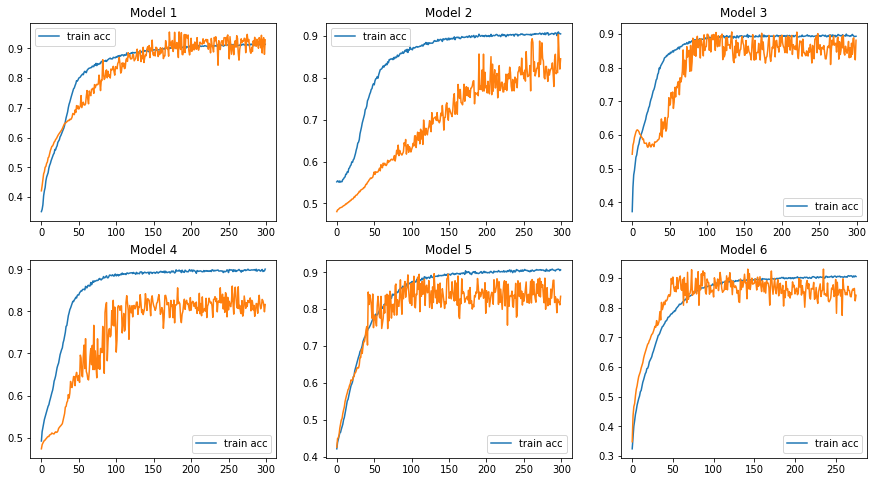

In [80]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

cnt = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[cnt]['sparse_categorical_accuracy']) 
        axs[i,j].plot(models_train_hist[cnt]['val_sparse_categorical_accuracy'])
        axs[i,j].set_title(f'Model {cnt + 1}')
        axs[i,j].legend(['train acc',], loc='best')
        cnt += 1
    
    
plt.show()
#fib.savefig('./training_acc.png', bbox_inches='tight', pad_inches=0)


model_n 1
model_n 3
model_n 5


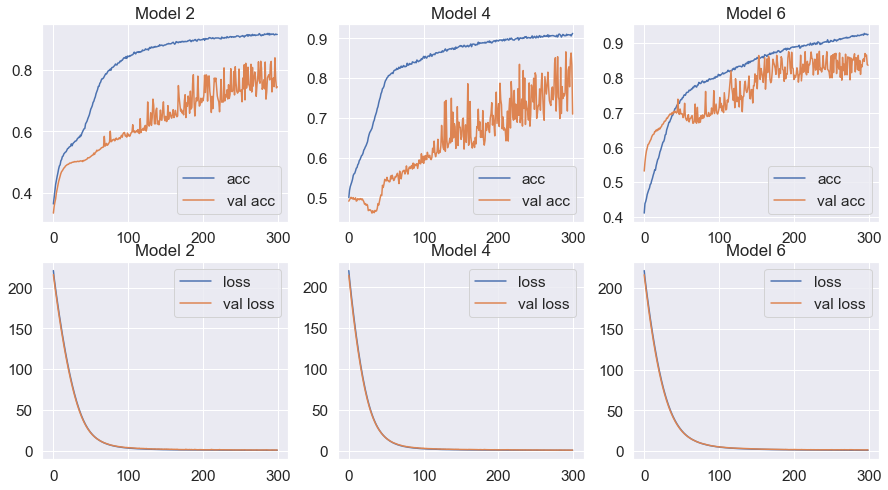

In [57]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

for j, model_n in zip(range(3), [1, 3, 5]):
    axs[0,j].plot(models_train_hist[model_n]['sparse_categorical_accuracy']) 
    axs[0,j].plot(models_train_hist[model_n]['val_sparse_categorical_accuracy'])
    axs[0,j].set_title(f'Model {model_n + 1}')
    axs[0,j].legend(['acc', 'val acc',], loc='best')
    cnt += 1

for j, model_n in zip(range(3), [1, 3, 5]):
    print(f'model_n {model_n}')
    axs[1,j].plot(models_train_hist[model_n]['loss']) 
    axs[1,j].plot(models_train_hist[model_n]['val_loss'])
    axs[1,j].set_title(f'Model {model_n + 1}')
    axs[1,j].legend(['loss', 'val loss',], loc='best')
    cnt += 1
    
plt.show()


In [58]:
folds_stats_t = folds_stats

avg_acc = 0
for i in range(len(folds_stats_t)):
    avg_acc = avg_acc + folds_stats_t[i][1]
    if i == len(folds_stats_t) - 1:
        avg_acc = avg_acc / len(folds_stats_t)

avg_loss = 0
for i in range(len(folds_stats_t)):
    avg_loss = avg_loss + folds_stats_t[i][0]
    if i == len(folds_stats_t) - 1:
        avg_loss = avg_loss / len(folds_stats_t)

print(f'AVG test acc: {avg_acc}')
print(f'AVG test loss: {avg_loss}')
print(folds_stats_t)

AVG test acc: 0
AVG test loss: 0
[]


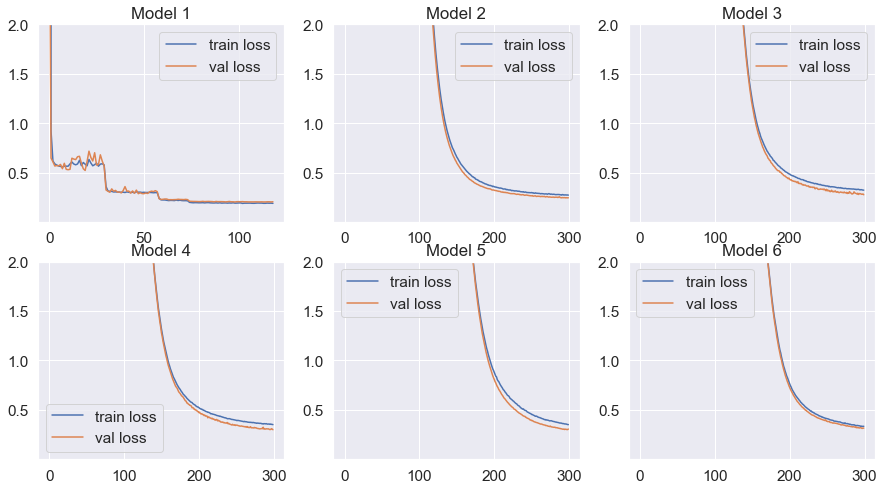

In [201]:
fib, axs = plt.subplots(2, 3, figsize=(15,8))

cnt = 0
for i in range(2):
    for j in range(3):
        axs[i,j].plot(models_train_hist[cnt]['loss']) 
        axs[i,j].plot(models_train_hist[cnt]['val_loss'])
        axs[i,j].set_title(f'Model {cnt + 1}')
        axs[i,j].set_ylim(0.0001, 2)
        axs[i,j].legend(['train loss', 'val loss',], loc='best')
        cnt += 1
    
    
plt.show()
# fib.savefig('./dist_chars.png', bbox_inches='tight', pad_inches=0)

## Finetuning

In [24]:
fine_models_train_hist = dict()
fine_folds_stats = dict()

for i in range(6):
    fine_models_train_hist[i] = dict()
    fine_folds_stats[i] = dict()
    for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
        fine_models_train_hist[i][reg] = dict()
        fine_folds_stats[i][reg] = []

In [127]:
# hyper-parameters #
fine_epochs = 150
fine_batch_size = 16
fine_kernel_size = 5
fine_filters = 64
fine_learning_rate = 0.00001
fine_regularizer = keras.regularizers.l1_l2(0.07)
fine_CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001
    )
]

In [128]:
def load_model(num, reg):
    build = True
    
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    if (os.path.exists(m_name_tuned)):
        print(f'loading prev tuned {m_name_tuned}')
        return keras.models.load_model(m_name_tuned), not build

    m_name_untuned = f'./best_model_{num}.tf'
    print(f'loading non-tuned {m_name_untuned}')
    return keras.models.load_model(m_name_untuned), build


def save_model_tune(model, num, reg):
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    
    print(f'saving {m_name_tuned}')
    model.save(m_name_tuned)

def build_model_funetune(base_model, input_shape, num_classes, filters, 
                         kernel_size, dropout_rate, regularizer):
    assert base_model is not None
    model = keras.Sequential()
    
    # freeze the base model
    base_model.trainable = False
    # add all layers except the last two
    for layer in base_model.layers[:-2]: 
        model.add(layer)
        
    
    model.add(keras.layers.Conv1D(filters=16, kernel_size=kernel_size, 
                                padding="same",
                                activation='relu',
                                name=f'Conv1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.BatchNormalization(
        name=f'BatchNormalization_{str(len(model.layers) + 1)}'
    ))
    model.add(keras.layers.Dropout(0.5, name=f'Dropout_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.GlobalAveragePooling1D(name=f'GlobalAveragePooling1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.Dense(num_classes, activation='softmax',
                                 name=f'Dense_{str(len(model.layers) + 1)}'))
        
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=fine_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])
    
    return model

In [32]:
print(iterations)

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


## Region training

In [129]:
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        
        print(f'Running fold on {reg} {i + 1}')
        print(f'Loading model {i} for region {reg}')
        model, build = load_model(i, reg.name)
        if build:
            print(f'building model {reg} {i}')
            model = build_model_funetune(
                model,
                x_train.shape[1:], 
                len(ProficiencyLabel), 
                kernel_size=fine_kernel_size, 
                filters=fine_filters, 
                dropout_rate=fine_dropout_rate, 
                regularizer=fine_regularizer,
            )
        
        
        history = model.fit(
            x_train,
            y_train,
            batch_size=fine_batch_size,
            epochs=fine_epochs,
            callbacks=fine_CALLBACKS,
            validation_data=(x_val, y_val),
            verbose=1,
        )
        fine_models_train_hist[i][reg] = history.history

        save_model_tune(model, i, reg)

Running fold on Scan.LUQ 1
Loading model 0 for region Scan.LUQ
loading non-tuned ./best_model_0.tf
building model Scan.LUQ 0
Epoch 1/150
416/416 [==============================] - 3s 5ms/step - loss: 1.3154 - sparse_categorical_accuracy: 0.4612 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.7381
Epoch 2/150
416/416 [==============================] - 2s 5ms/step - loss: 1.1310 - sparse_categorical_accuracy: 0.6030 - val_loss: 0.9016 - val_sparse_categorical_accuracy: 0.8533
Epoch 3/150
416/416 [==============================] - 2s 4ms/step - loss: 1.0180 - sparse_categorical_accuracy: 0.7082 - val_loss: 0.8078 - val_sparse_categorical_accuracy: 0.8527
Epoch 4/150
416/416 [==============================] - 2s 4ms/step - loss: 0.9671 - sparse_categorical_accuracy: 0.7372 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.8580
Epoch 5/150
416/416 [==============================] - 2s 4ms/step - loss: 0.9141 - sparse_categorical_accuracy: 0.7779 - val_loss: 0.7215 - val_sparse

416/416 [==============================] - 2s 4ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.8671 - val_loss: 0.4982 - val_sparse_categorical_accuracy: 0.9002
Epoch 46/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6046 - sparse_categorical_accuracy: 0.8750 - val_loss: 0.4941 - val_sparse_categorical_accuracy: 0.9069
Epoch 47/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6246 - sparse_categorical_accuracy: 0.8649 - val_loss: 0.5068 - val_sparse_categorical_accuracy: 0.8890
Epoch 48/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.5130 - val_sparse_categorical_accuracy: 0.8847
Epoch 49/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6328 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.5039 - val_sparse_categorical_accuracy: 0.8912
Epoch 50/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5898 - sparse_categorical

416/416 [==============================] - 2s 4ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.8663 - val_loss: 0.5076 - val_sparse_categorical_accuracy: 0.8744
Epoch 91/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6170 - sparse_categorical_accuracy: 0.8677 - val_loss: 0.5118 - val_sparse_categorical_accuracy: 0.8668
Epoch 92/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.5087 - val_sparse_categorical_accuracy: 0.8688
Epoch 93/150
416/416 [==============================] - 2s 5ms/step - loss: 0.6004 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.5095 - val_sparse_categorical_accuracy: 0.8704
Epoch 94/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6108 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.4978 - val_sparse_categorical_accuracy: 0.8850
Epoch 95/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5704 - sparse_categorical

Epoch 135/150
416/416 [==============================] - 2s 5ms/step - loss: 0.6057 - sparse_categorical_accuracy: 0.8657 - val_loss: 0.5156 - val_sparse_categorical_accuracy: 0.8572
Epoch 136/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.8527
Epoch 137/150
416/416 [==============================] - 2s 5ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.8697 - val_loss: 0.5079 - val_sparse_categorical_accuracy: 0.8693
Epoch 138/150
416/416 [==============================] - 2s 5ms/step - loss: 0.6088 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8861
Epoch 139/150
416/416 [==============================] - 2s 5ms/step - loss: 0.6137 - sparse_categorical_accuracy: 0.8580 - val_loss: 0.5060 - val_sparse_categorical_accuracy: 0.8737
Epoch 140/150
416/416 [==============================] - 2s 5ms/step - loss: 0.6120 -

Epoch 29/150
416/416 [==============================] - 2s 5ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.8532 - val_loss: 0.8088 - val_sparse_categorical_accuracy: 0.7537
Epoch 30/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.8309 - val_sparse_categorical_accuracy: 0.7115
Epoch 31/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.8128 - val_sparse_categorical_accuracy: 0.7311
Epoch 32/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.8440 - val_loss: 0.7878 - val_sparse_categorical_accuracy: 0.8133
Epoch 33/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.8004 - val_sparse_categorical_accuracy: 0.7470
Epoch 34/150
416/416 [==============================] - 2s 4ms/step - loss: 0.6672 - spars

416/416 [==============================] - 2s 4ms/step - loss: 0.5847 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.6268 - val_sparse_categorical_accuracy: 0.8970
Epoch 75/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5618 - sparse_categorical_accuracy: 0.8808 - val_loss: 0.6217 - val_sparse_categorical_accuracy: 0.8961
Epoch 76/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5909 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.6348 - val_sparse_categorical_accuracy: 0.9098
Epoch 77/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5927 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.6155 - val_sparse_categorical_accuracy: 0.8958
Epoch 78/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5744 - sparse_categorical_accuracy: 0.8783 - val_loss: 0.6171 - val_sparse_categorical_accuracy: 0.8984
Epoch 79/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5800 - sparse_categorical

Epoch 119/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5763 - sparse_categorical_accuracy: 0.8754 - val_loss: 0.5782 - val_sparse_categorical_accuracy: 0.9165
Epoch 120/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5770 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.5766 - val_sparse_categorical_accuracy: 0.9145
Epoch 121/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5746 - sparse_categorical_accuracy: 0.8710 - val_loss: 0.5768 - val_sparse_categorical_accuracy: 0.9200
Epoch 122/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.8684 - val_loss: 0.5779 - val_sparse_categorical_accuracy: 0.9223
Epoch 123/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5785 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.5767 - val_sparse_categorical_accuracy: 0.9181
Epoch 124/150
416/416 [==============================] - 2s 4ms/step - loss: 0.5890 -

537/537 [==============================] - 2s 3ms/step - loss: 0.7364 - sparse_categorical_accuracy: 0.7949 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.8792
Epoch 13/150
537/537 [==============================] - 2s 3ms/step - loss: 0.7307 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.8797
Epoch 14/150
537/537 [==============================] - 2s 3ms/step - loss: 0.7152 - sparse_categorical_accuracy: 0.8043 - val_loss: 0.6453 - val_sparse_categorical_accuracy: 0.9122
Epoch 15/150
537/537 [==============================] - 2s 3ms/step - loss: 0.7254 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.6391 - val_sparse_categorical_accuracy: 0.9144
Epoch 16/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6937 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.6255 - val_sparse_categorical_accuracy: 0.9292
Epoch 17/150
537/537 [==============================] - 2s 3ms/step - loss: 0.7120 - sparse_categorical

537/537 [==============================] - 2s 3ms/step - loss: 0.6102 - sparse_categorical_accuracy: 0.8076 - val_loss: 0.5321 - val_sparse_categorical_accuracy: 0.9218
Epoch 58/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5965 - sparse_categorical_accuracy: 0.8145 - val_loss: 0.5332 - val_sparse_categorical_accuracy: 0.9240
Epoch 59/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5944 - sparse_categorical_accuracy: 0.8162 - val_loss: 0.5341 - val_sparse_categorical_accuracy: 0.9153
Epoch 60/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6026 - sparse_categorical_accuracy: 0.8147 - val_loss: 0.5359 - val_sparse_categorical_accuracy: 0.9301
Epoch 61/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6138 - sparse_categorical_accuracy: 0.8061 - val_loss: 0.5364 - val_sparse_categorical_accuracy: 0.9210
Epoch 62/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6052 - sparse_categorical

537/537 [==============================] - 2s 3ms/step - loss: 0.5945 - sparse_categorical_accuracy: 0.8114 - val_loss: 0.5412 - val_sparse_categorical_accuracy: 0.9240
Epoch 103/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5925 - sparse_categorical_accuracy: 0.8083 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.9310
Epoch 104/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.8038 - val_loss: 0.5430 - val_sparse_categorical_accuracy: 0.9285
Epoch 105/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5979 - sparse_categorical_accuracy: 0.8100 - val_loss: 0.5400 - val_sparse_categorical_accuracy: 0.9180
Epoch 106/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6132 - sparse_categorical_accuracy: 0.8025 - val_loss: 0.5444 - val_sparse_categorical_accuracy: 0.9260
Epoch 107/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6033 - sparse_catego

Epoch 147/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5794 - sparse_categorical_accuracy: 0.8135 - val_loss: 0.5453 - val_sparse_categorical_accuracy: 0.9240
Epoch 148/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.8090 - val_loss: 0.5505 - val_sparse_categorical_accuracy: 0.9385
Epoch 149/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5773 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.5463 - val_sparse_categorical_accuracy: 0.9331
Epoch 150/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5876 - sparse_categorical_accuracy: 0.8114 - val_loss: 0.5437 - val_sparse_categorical_accuracy: 0.9177
saving ./best_model_tuned_2_Scan.LUQ.tf
INFO:tensorflow:Assets written to: ./best_model_tuned_2_Scan.LUQ.tf/assets
Running fold on Scan.LUQ 4
Loading model 3 for region Scan.LUQ
loading non-tuned ./best_model_3.tf
building model Scan.LUQ 3
Epoch 1/150
537/537 [=======

Epoch 41/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6683 - sparse_categorical_accuracy: 0.7962 - val_loss: 0.5898 - val_sparse_categorical_accuracy: 0.8711
Epoch 42/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.5866 - val_sparse_categorical_accuracy: 0.8643
Epoch 43/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.5850 - val_sparse_categorical_accuracy: 0.8644
Epoch 44/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6146 - sparse_categorical_accuracy: 0.8174 - val_loss: 0.5841 - val_sparse_categorical_accuracy: 0.8705
Epoch 45/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.8162 - val_loss: 0.5836 - val_sparse_categorical_accuracy: 0.8826
Epoch 46/150
537/537 [==============================] - 2s 3ms/step - loss: 0.6057 - spars

537/537 [==============================] - 2s 3ms/step - loss: 0.5875 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.5702 - val_sparse_categorical_accuracy: 0.8707
Epoch 87/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5798 - sparse_categorical_accuracy: 0.8058 - val_loss: 0.5719 - val_sparse_categorical_accuracy: 0.8698
Epoch 88/150
537/537 [==============================] - 2s 4ms/step - loss: 0.5882 - sparse_categorical_accuracy: 0.8015 - val_loss: 0.5717 - val_sparse_categorical_accuracy: 0.8791
Epoch 89/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.8159 - val_loss: 0.5710 - val_sparse_categorical_accuracy: 0.8693
Epoch 90/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5683 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.5702 - val_sparse_categorical_accuracy: 0.8574
Epoch 91/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5785 - sparse_categorical

Epoch 131/150
537/537 [==============================] - 2s 4ms/step - loss: 0.5827 - sparse_categorical_accuracy: 0.8041 - val_loss: 0.5754 - val_sparse_categorical_accuracy: 0.8868
Epoch 132/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.8175 - val_loss: 0.5733 - val_sparse_categorical_accuracy: 0.8627
Epoch 133/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5804 - sparse_categorical_accuracy: 0.8101 - val_loss: 0.5725 - val_sparse_categorical_accuracy: 0.8733
Epoch 134/150
537/537 [==============================] - 2s 4ms/step - loss: 0.5702 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.5720 - val_sparse_categorical_accuracy: 0.8651
Epoch 135/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5764 - sparse_categorical_accuracy: 0.8096 - val_loss: 0.5732 - val_sparse_categorical_accuracy: 0.8725
Epoch 136/150
537/537 [==============================] - 2s 3ms/step - loss: 0.5880 -

466/466 [==============================] - 2s 4ms/step - loss: 0.7086 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.4950 - val_sparse_categorical_accuracy: 0.9553
Epoch 25/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6984 - sparse_categorical_accuracy: 0.8472 - val_loss: 0.4953 - val_sparse_categorical_accuracy: 0.9553
Epoch 26/150
466/466 [==============================] - 2s 3ms/step - loss: 0.6980 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.4908 - val_sparse_categorical_accuracy: 0.9553
Epoch 27/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6843 - sparse_categorical_accuracy: 0.8501 - val_loss: 0.4884 - val_sparse_categorical_accuracy: 0.9553
Epoch 28/150
466/466 [==============================] - 2s 3ms/step - loss: 0.7018 - sparse_categorical_accuracy: 0.8395 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.9553
Epoch 29/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6796 - sparse_categorical

466/466 [==============================] - 2s 4ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.8495 - val_loss: 0.4757 - val_sparse_categorical_accuracy: 0.9261
Epoch 70/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6058 - sparse_categorical_accuracy: 0.8632 - val_loss: 0.4731 - val_sparse_categorical_accuracy: 0.9269
Epoch 71/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6223 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.4771 - val_sparse_categorical_accuracy: 0.9231
Epoch 72/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.8503 - val_loss: 0.4804 - val_sparse_categorical_accuracy: 0.9191
Epoch 73/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.8460 - val_loss: 0.4752 - val_sparse_categorical_accuracy: 0.9255
Epoch 74/150
466/466 [==============================] - 2s 3ms/step - loss: 0.5942 - sparse_categorical

466/466 [==============================] - 2s 4ms/step - loss: 0.5923 - sparse_categorical_accuracy: 0.8644 - val_loss: 0.4833 - val_sparse_categorical_accuracy: 0.9191
Epoch 115/150
466/466 [==============================] - 2s 3ms/step - loss: 0.6188 - sparse_categorical_accuracy: 0.8528 - val_loss: 0.4775 - val_sparse_categorical_accuracy: 0.9263
Epoch 116/150
466/466 [==============================] - 2s 3ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.8554 - val_loss: 0.4836 - val_sparse_categorical_accuracy: 0.9185
Epoch 117/150
466/466 [==============================] - 2s 3ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.4813 - val_sparse_categorical_accuracy: 0.9219
Epoch 118/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6014 - sparse_categorical_accuracy: 0.8577 - val_loss: 0.4819 - val_sparse_categorical_accuracy: 0.9209
Epoch 119/150
466/466 [==============================] - 2s 5ms/step - loss: 0.5933 - sparse_catego

466/466 [==============================] - 3s 7ms/step - loss: 0.9537 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.6352 - val_sparse_categorical_accuracy: 0.9476
Epoch 8/150
466/466 [==============================] - 3s 7ms/step - loss: 0.9136 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.6139 - val_sparse_categorical_accuracy: 0.9529
Epoch 9/150
466/466 [==============================] - 4s 8ms/step - loss: 0.8796 - sparse_categorical_accuracy: 0.7965 - val_loss: 0.5973 - val_sparse_categorical_accuracy: 0.9578
Epoch 10/150
466/466 [==============================] - 3s 7ms/step - loss: 0.8763 - sparse_categorical_accuracy: 0.7897 - val_loss: 0.5880 - val_sparse_categorical_accuracy: 0.9561
Epoch 11/150
466/466 [==============================] - 3s 7ms/step - loss: 0.8344 - sparse_categorical_accuracy: 0.8079 - val_loss: 0.5737 - val_sparse_categorical_accuracy: 0.9636
Epoch 12/150
466/466 [==============================] - 2s 5ms/step - loss: 0.8120 - sparse_categorical_a

466/466 [==============================] - 3s 7ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.4291 - val_sparse_categorical_accuracy: 0.9442
Epoch 53/150
466/466 [==============================] - 3s 7ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.4333 - val_sparse_categorical_accuracy: 0.9396
Epoch 54/150
466/466 [==============================] - 3s 7ms/step - loss: 0.6200 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.4304 - val_sparse_categorical_accuracy: 0.9405
Epoch 55/150
466/466 [==============================] - 3s 7ms/step - loss: 0.6261 - sparse_categorical_accuracy: 0.8457 - val_loss: 0.4295 - val_sparse_categorical_accuracy: 0.9407
Epoch 56/150
466/466 [==============================] - 3s 7ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.4300 - val_sparse_categorical_accuracy: 0.9400
Epoch 57/150
466/466 [==============================] - 4s 8ms/step - loss: 0.6296 - sparse_categorical

466/466 [==============================] - 4s 8ms/step - loss: 0.6023 - sparse_categorical_accuracy: 0.8510 - val_loss: 0.4248 - val_sparse_categorical_accuracy: 0.9430
Epoch 98/150
466/466 [==============================] - 4s 8ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.4188 - val_sparse_categorical_accuracy: 0.9519
Epoch 99/150
466/466 [==============================] - 4s 9ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.8499 - val_loss: 0.4221 - val_sparse_categorical_accuracy: 0.9470
Epoch 100/150
466/466 [==============================] - 4s 9ms/step - loss: 0.6022 - sparse_categorical_accuracy: 0.8493 - val_loss: 0.4233 - val_sparse_categorical_accuracy: 0.9448
Epoch 101/150
466/466 [==============================] - 4s 9ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.8413 - val_loss: 0.4264 - val_sparse_categorical_accuracy: 0.9420
Epoch 102/150
466/466 [==============================] - 4127s 9s/step - loss: 0.6001 - sparse_catego

Epoch 142/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.8336 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.9450
Epoch 143/150
466/466 [==============================] - 2s 4ms/step - loss: 0.5927 - sparse_categorical_accuracy: 0.8461 - val_loss: 0.4303 - val_sparse_categorical_accuracy: 0.9325
Epoch 144/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.8482 - val_loss: 0.4192 - val_sparse_categorical_accuracy: 0.9486
Epoch 145/150
466/466 [==============================] - 2s 4ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.4225 - val_sparse_categorical_accuracy: 0.9473
Epoch 146/150
466/466 [==============================] - 2s 4ms/step - loss: 0.5849 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 0.9543
Epoch 147/150
466/466 [==============================] - 2s 4ms/step - loss: 0.5660 -

Epoch 36/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4200 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.8710
Epoch 37/150
377/377 [==============================] - 2s 4ms/step - loss: 0.4230 - sparse_categorical_accuracy: 0.9433 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.8714
Epoch 38/150
377/377 [==============================] - 2s 4ms/step - loss: 0.4420 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.6584 - val_sparse_categorical_accuracy: 0.8748
Epoch 39/150
377/377 [==============================] - 2s 4ms/step - loss: 0.4258 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.8725
Epoch 40/150
377/377 [==============================] - 2s 5ms/step - loss: 0.4220 - sparse_categorical_accuracy: 0.9448 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.8730
Epoch 41/150
377/377 [==============================] - 2s 4ms/step - loss: 0.4192 - spars

377/377 [==============================] - 1s 4ms/step - loss: 0.4157 - sparse_categorical_accuracy: 0.9398 - val_loss: 0.6983 - val_sparse_categorical_accuracy: 0.8708
Epoch 82/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4198 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.6846 - val_sparse_categorical_accuracy: 0.8736
Epoch 83/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3882 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.7135 - val_sparse_categorical_accuracy: 0.8671
Epoch 84/150
377/377 [==============================] - 1s 3ms/step - loss: 0.4165 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.6809 - val_sparse_categorical_accuracy: 0.8741
Epoch 85/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4099 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.6881 - val_sparse_categorical_accuracy: 0.8729
Epoch 86/150
377/377 [==============================] - 1s 3ms/step - loss: 0.3981 - sparse_categorical

Epoch 126/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4056 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.8724
Epoch 127/150
377/377 [==============================] - 1s 3ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.8720
Epoch 128/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4023 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.7037 - val_sparse_categorical_accuracy: 0.8702
Epoch 129/150
377/377 [==============================] - 1s 3ms/step - loss: 0.3985 - sparse_categorical_accuracy: 0.9423 - val_loss: 0.6797 - val_sparse_categorical_accuracy: 0.8755
Epoch 130/150
377/377 [==============================] - 1s 3ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.7081 - val_sparse_categorical_accuracy: 0.8691
Epoch 131/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3843 -

377/377 [==============================] - 1s 4ms/step - loss: 0.4981 - sparse_categorical_accuracy: 0.9320 - val_loss: 0.9190 - val_sparse_categorical_accuracy: 0.7882
Epoch 20/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4897 - sparse_categorical_accuracy: 0.9331 - val_loss: 0.9197 - val_sparse_categorical_accuracy: 0.7885
Epoch 21/150
377/377 [==============================] - 1s 3ms/step - loss: 0.4962 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.9182 - val_sparse_categorical_accuracy: 0.7885
Epoch 22/150
377/377 [==============================] - 1s 3ms/step - loss: 0.4905 - sparse_categorical_accuracy: 0.9310 - val_loss: 0.9126 - val_sparse_categorical_accuracy: 0.7892
Epoch 23/150
377/377 [==============================] - 1s 3ms/step - loss: 0.4695 - sparse_categorical_accuracy: 0.9377 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.7874
Epoch 24/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4641 - sparse_categorical

377/377 [==============================] - 1s 4ms/step - loss: 0.4127 - sparse_categorical_accuracy: 0.9366 - val_loss: 0.9090 - val_sparse_categorical_accuracy: 0.7923
Epoch 65/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3921 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.9237 - val_sparse_categorical_accuracy: 0.7896
Epoch 66/150
377/377 [==============================] - 1s 4ms/step - loss: 0.4013 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.9028 - val_sparse_categorical_accuracy: 0.7941
Epoch 67/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3872 - sparse_categorical_accuracy: 0.9480 - val_loss: 0.9115 - val_sparse_categorical_accuracy: 0.7919
Epoch 68/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3916 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.9077 - val_sparse_categorical_accuracy: 0.7935
Epoch 69/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3903 - sparse_categorical

377/377 [==============================] - 1s 4ms/step - loss: 0.3943 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.9050 - val_sparse_categorical_accuracy: 0.7976
Epoch 110/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3868 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.9037 - val_sparse_categorical_accuracy: 0.7976
Epoch 111/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3862 - sparse_categorical_accuracy: 0.9454 - val_loss: 0.9034 - val_sparse_categorical_accuracy: 0.7975
Epoch 112/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3865 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.9104 - val_sparse_categorical_accuracy: 0.7964
Epoch 113/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3870 - sparse_categorical_accuracy: 0.9474 - val_loss: 0.9063 - val_sparse_categorical_accuracy: 0.7967
Epoch 114/150
377/377 [==============================] - 1s 4ms/step - loss: 0.3893 - sparse_catego

466/466 [==============================] - 2s 3ms/step - loss: 0.8676 - sparse_categorical_accuracy: 0.7793 - val_loss: 0.9528 - val_sparse_categorical_accuracy: 0.7154
Epoch 3/150
466/466 [==============================] - 1s 3ms/step - loss: 0.7649 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.9128 - val_sparse_categorical_accuracy: 0.7264
Epoch 4/150
466/466 [==============================] - 1s 3ms/step - loss: 0.6783 - sparse_categorical_accuracy: 0.8982 - val_loss: 0.8941 - val_sparse_categorical_accuracy: 0.7302
Epoch 5/150
466/466 [==============================] - 1s 3ms/step - loss: 0.6069 - sparse_categorical_accuracy: 0.9299 - val_loss: 0.8682 - val_sparse_categorical_accuracy: 0.7407
Epoch 6/150
466/466 [==============================] - 1s 3ms/step - loss: 0.5794 - sparse_categorical_accuracy: 0.9327 - val_loss: 0.8496 - val_sparse_categorical_accuracy: 0.7485
Epoch 7/150
466/466 [==============================] - 1s 3ms/step - loss: 0.5433 - sparse_categorical_accu

466/466 [==============================] - 2s 4ms/step - loss: 0.2637 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.7989 - val_sparse_categorical_accuracy: 0.7911
Epoch 48/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2568 - sparse_categorical_accuracy: 0.9687 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.7948
Epoch 49/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2524 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.7862 - val_sparse_categorical_accuracy: 0.7943
Epoch 50/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2505 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.7637 - val_sparse_categorical_accuracy: 0.7968
Epoch 51/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2463 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.8034 - val_sparse_categorical_accuracy: 0.7916
Epoch 52/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2483 - sparse_categorical

466/466 [==============================] - 1s 3ms/step - loss: 0.2378 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.8118 - val_sparse_categorical_accuracy: 0.7974
Epoch 93/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2367 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.8147 - val_sparse_categorical_accuracy: 0.7974
Epoch 94/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2485 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.8207 - val_sparse_categorical_accuracy: 0.7966
Epoch 95/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2403 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.8298 - val_sparse_categorical_accuracy: 0.7953
Epoch 96/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.7950
Epoch 97/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2328 - sparse_categorical

Epoch 137/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2353 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.8275 - val_sparse_categorical_accuracy: 0.7963
Epoch 138/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2334 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.8220 - val_sparse_categorical_accuracy: 0.7973
Epoch 139/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2433 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.8507 - val_sparse_categorical_accuracy: 0.7931
Epoch 140/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2347 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.8415 - val_sparse_categorical_accuracy: 0.7940
Epoch 141/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2464 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.8480 - val_sparse_categorical_accuracy: 0.7936
Epoch 142/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2352 -

Epoch 31/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2856 - sparse_categorical_accuracy: 0.9691 - val_loss: 1.0840 - val_sparse_categorical_accuracy: 0.6563
Epoch 32/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2836 - sparse_categorical_accuracy: 0.9696 - val_loss: 1.0412 - val_sparse_categorical_accuracy: 0.6697
Epoch 33/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2777 - sparse_categorical_accuracy: 0.9720 - val_loss: 1.0569 - val_sparse_categorical_accuracy: 0.6646
Epoch 34/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.9707 - val_loss: 1.1253 - val_sparse_categorical_accuracy: 0.6488
Epoch 35/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2687 - sparse_categorical_accuracy: 0.9737 - val_loss: 1.0747 - val_sparse_categorical_accuracy: 0.6621
Epoch 36/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2656 - spars

466/466 [==============================] - 1s 3ms/step - loss: 0.2496 - sparse_categorical_accuracy: 0.9707 - val_loss: 1.2322 - val_sparse_categorical_accuracy: 0.6439
Epoch 77/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2525 - sparse_categorical_accuracy: 0.9725 - val_loss: 1.1967 - val_sparse_categorical_accuracy: 0.6509
Epoch 78/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2512 - sparse_categorical_accuracy: 0.9728 - val_loss: 1.2400 - val_sparse_categorical_accuracy: 0.6432
Epoch 79/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9689 - val_loss: 1.2532 - val_sparse_categorical_accuracy: 0.6414
Epoch 80/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9674 - val_loss: 1.2152 - val_sparse_categorical_accuracy: 0.6463
Epoch 81/150
466/466 [==============================] - 2s 4ms/step - loss: 0.2511 - sparse_categorical

Epoch 121/150
466/466 [==============================] - 2s 5ms/step - loss: 0.2498 - sparse_categorical_accuracy: 0.9717 - val_loss: 1.2534 - val_sparse_categorical_accuracy: 0.6442
Epoch 122/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2468 - sparse_categorical_accuracy: 0.9727 - val_loss: 1.2659 - val_sparse_categorical_accuracy: 0.6424
Epoch 123/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.9725 - val_loss: 1.2924 - val_sparse_categorical_accuracy: 0.6397
Epoch 124/150
466/466 [==============================] - 1s 3ms/step - loss: 0.2451 - sparse_categorical_accuracy: 0.9733 - val_loss: 1.1978 - val_sparse_categorical_accuracy: 0.6536
Epoch 125/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2417 - sparse_categorical_accuracy: 0.9754 - val_loss: 1.2274 - val_sparse_categorical_accuracy: 0.6508
Epoch 126/150
466/466 [==============================] - 2s 3ms/step - loss: 0.2372 -

466/466 [==============================] - 1s 3ms/step - loss: 0.5784 - sparse_categorical_accuracy: 0.9188 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.7410
Epoch 15/150
466/466 [==============================] - 1s 3ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.9180 - val_loss: 1.0246 - val_sparse_categorical_accuracy: 0.7481
Epoch 16/150
466/466 [==============================] - 1s 3ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.9188 - val_loss: 1.0288 - val_sparse_categorical_accuracy: 0.7524
Epoch 17/150
466/466 [==============================] - 1s 3ms/step - loss: 0.5536 - sparse_categorical_accuracy: 0.9205 - val_loss: 1.0280 - val_sparse_categorical_accuracy: 0.7586
Epoch 18/150
466/466 [==============================] - 1s 3ms/step - loss: 0.5384 - sparse_categorical_accuracy: 0.9273 - val_loss: 1.0237 - val_sparse_categorical_accuracy: 0.7619
Epoch 19/150
466/466 [==============================] - 2s 3ms/step - loss: 0.5139 - sparse_categorical

466/466 [==============================] - 2s 4ms/step - loss: 0.3751 - sparse_categorical_accuracy: 0.9567 - val_loss: 1.0407 - val_sparse_categorical_accuracy: 0.8137
Epoch 60/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3623 - sparse_categorical_accuracy: 0.9608 - val_loss: 1.0640 - val_sparse_categorical_accuracy: 0.8119
Epoch 61/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3579 - sparse_categorical_accuracy: 0.9610 - val_loss: 1.0687 - val_sparse_categorical_accuracy: 0.8114
Epoch 62/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3607 - sparse_categorical_accuracy: 0.9610 - val_loss: 1.0334 - val_sparse_categorical_accuracy: 0.8126
Epoch 63/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.9592 - val_loss: 1.0373 - val_sparse_categorical_accuracy: 0.8134
Epoch 64/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3678 - sparse_categorical

466/466 [==============================] - 2s 4ms/step - loss: 0.3552 - sparse_categorical_accuracy: 0.9610 - val_loss: 1.0441 - val_sparse_categorical_accuracy: 0.8142
Epoch 105/150
466/466 [==============================] - 2s 5ms/step - loss: 0.3458 - sparse_categorical_accuracy: 0.9612 - val_loss: 1.0492 - val_sparse_categorical_accuracy: 0.8147
Epoch 106/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.9617 - val_loss: 1.0476 - val_sparse_categorical_accuracy: 0.8144
Epoch 107/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.9598 - val_loss: 1.0347 - val_sparse_categorical_accuracy: 0.8134
Epoch 108/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3507 - sparse_categorical_accuracy: 0.9615 - val_loss: 1.0421 - val_sparse_categorical_accuracy: 0.8132
Epoch 109/150
466/466 [==============================] - 2s 3ms/step - loss: 0.3440 - sparse_catego

Epoch 149/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3434 - sparse_categorical_accuracy: 0.9626 - val_loss: 1.0575 - val_sparse_categorical_accuracy: 0.8155
Epoch 150/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3616 - sparse_categorical_accuracy: 0.9566 - val_loss: 1.0292 - val_sparse_categorical_accuracy: 0.8140
saving ./best_model_tuned_4_Scan.RUQ.tf
INFO:tensorflow:Assets written to: ./best_model_tuned_4_Scan.RUQ.tf/assets
Running fold on Scan.RUQ 6
Loading model 5 for region Scan.RUQ
loading non-tuned ./best_model_5.tf
building model Scan.RUQ 5
Epoch 1/150
466/466 [==============================] - 2s 4ms/step - loss: 1.1419 - sparse_categorical_accuracy: 0.5521 - val_loss: 1.0290 - val_sparse_categorical_accuracy: 0.6925
Epoch 2/150
466/466 [==============================] - 1s 3ms/step - loss: 0.9898 - sparse_categorical_accuracy: 0.7063 - val_loss: 1.0437 - val_sparse_categorical_accuracy: 0.7087
Epoch 3/150
466/466 [===========

Epoch 43/150
466/466 [==============================] - 2s 4ms/step - loss: 0.4086 - sparse_categorical_accuracy: 0.9499 - val_loss: 1.4333 - val_sparse_categorical_accuracy: 0.7699
Epoch 44/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3950 - sparse_categorical_accuracy: 0.9535 - val_loss: 1.4775 - val_sparse_categorical_accuracy: 0.7665
Epoch 45/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3898 - sparse_categorical_accuracy: 0.9533 - val_loss: 1.4749 - val_sparse_categorical_accuracy: 0.7680
Epoch 46/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3913 - sparse_categorical_accuracy: 0.9563 - val_loss: 1.4905 - val_sparse_categorical_accuracy: 0.7664
Epoch 47/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3871 - sparse_categorical_accuracy: 0.9537 - val_loss: 1.4683 - val_sparse_categorical_accuracy: 0.7681
Epoch 48/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3901 - spars

466/466 [==============================] - 2s 3ms/step - loss: 0.3800 - sparse_categorical_accuracy: 0.9535 - val_loss: 1.4674 - val_sparse_categorical_accuracy: 0.7717
Epoch 89/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3752 - sparse_categorical_accuracy: 0.9561 - val_loss: 1.5079 - val_sparse_categorical_accuracy: 0.7704
Epoch 90/150
466/466 [==============================] - 1s 3ms/step - loss: 0.3735 - sparse_categorical_accuracy: 0.9600 - val_loss: 1.4835 - val_sparse_categorical_accuracy: 0.7717
Epoch 91/150
466/466 [==============================] - 2s 3ms/step - loss: 0.3797 - sparse_categorical_accuracy: 0.9530 - val_loss: 1.4982 - val_sparse_categorical_accuracy: 0.7712
Epoch 92/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3639 - sparse_categorical_accuracy: 0.9627 - val_loss: 1.4724 - val_sparse_categorical_accuracy: 0.7721
Epoch 93/150
466/466 [==============================] - 2s 3ms/step - loss: 0.3800 - sparse_categorical

Epoch 133/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3645 - sparse_categorical_accuracy: 0.9564 - val_loss: 1.4522 - val_sparse_categorical_accuracy: 0.7748
Epoch 134/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3667 - sparse_categorical_accuracy: 0.9537 - val_loss: 1.5086 - val_sparse_categorical_accuracy: 0.7721
Epoch 135/150
466/466 [==============================] - 2s 3ms/step - loss: 0.3723 - sparse_categorical_accuracy: 0.9566 - val_loss: 1.5010 - val_sparse_categorical_accuracy: 0.7724
Epoch 136/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3624 - sparse_categorical_accuracy: 0.9564 - val_loss: 1.5133 - val_sparse_categorical_accuracy: 0.7721
Epoch 137/150
466/466 [==============================] - 2s 4ms/step - loss: 0.3641 - sparse_categorical_accuracy: 0.9590 - val_loss: 1.4316 - val_sparse_categorical_accuracy: 0.7767
Epoch 138/150
466/466 [==============================] - 2s 3ms/step - loss: 0.3578 -

180/180 [==============================] - 1s 5ms/step - loss: 0.4211 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.4440 - val_sparse_categorical_accuracy: 0.9641
Epoch 27/150
180/180 [==============================] - 1s 4ms/step - loss: 0.4181 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.4395 - val_sparse_categorical_accuracy: 0.9639
Epoch 28/150
180/180 [==============================] - 1s 4ms/step - loss: 0.4076 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.4348 - val_sparse_categorical_accuracy: 0.9641
Epoch 29/150
180/180 [==============================] - 1s 4ms/step - loss: 0.4185 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.4290 - val_sparse_categorical_accuracy: 0.9639
Epoch 30/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3986 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.4254 - val_sparse_categorical_accuracy: 0.9643
Epoch 31/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3966 - sparse_categorical

180/180 [==============================] - 1s 4ms/step - loss: 0.2863 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.3511 - val_sparse_categorical_accuracy: 0.9594
Epoch 72/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2984 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.3507 - val_sparse_categorical_accuracy: 0.9598
Epoch 73/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2924 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.3502 - val_sparse_categorical_accuracy: 0.9594
Epoch 74/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2975 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.3498 - val_sparse_categorical_accuracy: 0.9594
Epoch 75/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2946 - sparse_categorical_accuracy: 0.9883 - val_loss: 0.3488 - val_sparse_categorical_accuracy: 0.9598
Epoch 76/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2954 - sparse_categorical

Epoch 116/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2707 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.9559
Epoch 117/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2654 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.3438 - val_sparse_categorical_accuracy: 0.9559
Epoch 118/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.3440 - val_sparse_categorical_accuracy: 0.9563
Epoch 119/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2614 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.3437 - val_sparse_categorical_accuracy: 0.9566
Epoch 120/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2715 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.9559
Epoch 121/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2603 -

180/180 [==============================] - 1s 4ms/step - loss: 0.7724 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.6374 - val_sparse_categorical_accuracy: 0.9897
Epoch 10/150
180/180 [==============================] - 1s 5ms/step - loss: 0.7281 - sparse_categorical_accuracy: 0.9083 - val_loss: 0.6039 - val_sparse_categorical_accuracy: 0.9938
Epoch 11/150
180/180 [==============================] - 1s 4ms/step - loss: 0.7049 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.5697 - val_sparse_categorical_accuracy: 0.9966
Epoch 12/150
180/180 [==============================] - 1s 5ms/step - loss: 0.6800 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.5443 - val_sparse_categorical_accuracy: 0.9978
Epoch 13/150
180/180 [==============================] - 1s 5ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.5262 - val_sparse_categorical_accuracy: 0.9992
Epoch 14/150
180/180 [==============================] - 1s 5ms/step - loss: 0.6387 - sparse_categorical

180/180 [==============================] - 1s 4ms/step - loss: 0.3479 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.2929 - val_sparse_categorical_accuracy: 0.9801
Epoch 55/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3486 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.2921 - val_sparse_categorical_accuracy: 0.9799
Epoch 56/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3544 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.2917 - val_sparse_categorical_accuracy: 0.9799
Epoch 57/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3451 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.2909 - val_sparse_categorical_accuracy: 0.9793
Epoch 58/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3575 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.2892 - val_sparse_categorical_accuracy: 0.9791
Epoch 59/150
180/180 [==============================] - 1s 4ms/step - loss: 0.3318 - sparse_categorical

180/180 [==============================] - 1s 4ms/step - loss: 0.2895 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.2704 - val_sparse_categorical_accuracy: 0.9777
Epoch 100/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2935 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.2694 - val_sparse_categorical_accuracy: 0.9777
Epoch 101/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2903 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.9777
Epoch 102/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2924 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.2694 - val_sparse_categorical_accuracy: 0.9777
Epoch 103/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2779 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.2686 - val_sparse_categorical_accuracy: 0.9777
Epoch 104/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2855 - sparse_catego

Epoch 144/150
180/180 [==============================] - 1s 5ms/step - loss: 0.2673 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.2668 - val_sparse_categorical_accuracy: 0.9777
Epoch 145/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2681 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.2675 - val_sparse_categorical_accuracy: 0.9777
Epoch 146/150
180/180 [==============================] - 1s 5ms/step - loss: 0.2657 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.9777
Epoch 147/150
180/180 [==============================] - 1s 5ms/step - loss: 0.2544 - sparse_categorical_accuracy: 0.9931 - val_loss: 0.2664 - val_sparse_categorical_accuracy: 0.9777
Epoch 148/150
180/180 [==============================] - 1s 4ms/step - loss: 0.2558 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.9777
Epoch 149/150
180/180 [==============================] - 1s 5ms/step - loss: 0.2698 -

290/290 [==============================] - 1s 3ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.2877 - val_sparse_categorical_accuracy: 0.9632
Epoch 38/150
290/290 [==============================] - 1s 3ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.2873 - val_sparse_categorical_accuracy: 0.9618
Epoch 39/150
290/290 [==============================] - 1s 3ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.2843 - val_sparse_categorical_accuracy: 0.9628
Epoch 40/150
290/290 [==============================] - 1s 3ms/step - loss: 0.2196 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.2820 - val_sparse_categorical_accuracy: 0.9632
Epoch 41/150
290/290 [==============================] - 1s 3ms/step - loss: 0.2214 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.2801 - val_sparse_categorical_accuracy: 0.9639
Epoch 42/150
290/290 [==============================] - 1s 3ms/step - loss: 0.2117 - sparse_categorical

290/290 [==============================] - 1s 4ms/step - loss: 0.1870 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.2326 - val_sparse_categorical_accuracy: 0.9743
Epoch 83/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.2303 - val_sparse_categorical_accuracy: 0.9746
Epoch 84/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.2256 - val_sparse_categorical_accuracy: 0.9764
Epoch 85/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1892 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.2297 - val_sparse_categorical_accuracy: 0.9746
Epoch 86/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1848 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.2287 - val_sparse_categorical_accuracy: 0.9757
Epoch 87/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1742 - sparse_categorical

Epoch 127/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1683 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.2167 - val_sparse_categorical_accuracy: 0.9771
Epoch 128/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.2116 - val_sparse_categorical_accuracy: 0.9788
Epoch 129/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.2153 - val_sparse_categorical_accuracy: 0.9774
Epoch 130/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1670 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.2169 - val_sparse_categorical_accuracy: 0.9767
Epoch 131/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1641 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.2132 - val_sparse_categorical_accuracy: 0.9778
Epoch 132/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1623 -

290/290 [==============================] - 1s 3ms/step - loss: 0.4145 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.3626 - val_sparse_categorical_accuracy: 0.9743
Epoch 21/150
290/290 [==============================] - 1s 4ms/step - loss: 0.4007 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.3554 - val_sparse_categorical_accuracy: 0.9743
Epoch 22/150
290/290 [==============================] - 1s 4ms/step - loss: 0.4025 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.3447 - val_sparse_categorical_accuracy: 0.9755
Epoch 23/150
290/290 [==============================] - 1s 3ms/step - loss: 0.3857 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.3347 - val_sparse_categorical_accuracy: 0.9759
Epoch 24/150
290/290 [==============================] - 1s 4ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.3317 - val_sparse_categorical_accuracy: 0.9757
Epoch 25/150
290/290 [==============================] - 1s 4ms/step - loss: 0.3468 - sparse_categorical

290/290 [==============================] - 1s 4ms/step - loss: 0.2094 - sparse_categorical_accuracy: 0.9917 - val_loss: 0.2350 - val_sparse_categorical_accuracy: 0.9777
Epoch 66/150
290/290 [==============================] - 1s 4ms/step - loss: 0.2056 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.2343 - val_sparse_categorical_accuracy: 0.9777
Epoch 67/150
290/290 [==============================] - 1s 4ms/step - loss: 0.2066 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.2354 - val_sparse_categorical_accuracy: 0.9777
Epoch 68/150
290/290 [==============================] - 1s 4ms/step - loss: 0.2166 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.2324 - val_sparse_categorical_accuracy: 0.9777
Epoch 69/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1957 - sparse_categorical_accuracy: 0.9953 - val_loss: 0.2323 - val_sparse_categorical_accuracy: 0.9777
Epoch 70/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1907 - sparse_categorical

290/290 [==============================] - 1s 4ms/step - loss: 0.1707 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.9777
Epoch 111/150
290/290 [==============================] - 1s 5ms/step - loss: 0.1817 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.2303 - val_sparse_categorical_accuracy: 0.9777
Epoch 112/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.9777
Epoch 113/150
290/290 [==============================] - 1s 4ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.2306 - val_sparse_categorical_accuracy: 0.9777
Epoch 114/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.2301 - val_sparse_categorical_accuracy: 0.9777
Epoch 115/150
290/290 [==============================] - 1s 3ms/step - loss: 0.1766 - sparse_catego

311/311 [==============================] - 1s 3ms/step - loss: 0.9849 - sparse_categorical_accuracy: 0.6261 - val_loss: 1.0066 - val_sparse_categorical_accuracy: 0.7265
Epoch 4/150
311/311 [==============================] - 1s 3ms/step - loss: 0.8477 - sparse_categorical_accuracy: 0.7622 - val_loss: 0.9493 - val_sparse_categorical_accuracy: 0.8106
Epoch 5/150
311/311 [==============================] - 1s 3ms/step - loss: 0.7507 - sparse_categorical_accuracy: 0.8628 - val_loss: 0.8984 - val_sparse_categorical_accuracy: 0.8311
Epoch 6/150
311/311 [==============================] - 1s 3ms/step - loss: 0.6681 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.8638 - val_sparse_categorical_accuracy: 0.8328
Epoch 7/150
311/311 [==============================] - 1s 3ms/step - loss: 0.6179 - sparse_categorical_accuracy: 0.9341 - val_loss: 0.8366 - val_sparse_categorical_accuracy: 0.8349
Epoch 8/150
311/311 [==============================] - 1s 3ms/step - loss: 0.5813 - sparse_categorical_accu

311/311 [==============================] - 1s 3ms/step - loss: 0.2826 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.8467
Epoch 49/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2737 - sparse_categorical_accuracy: 0.9919 - val_loss: 0.7382 - val_sparse_categorical_accuracy: 0.8485
Epoch 50/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2757 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.7372 - val_sparse_categorical_accuracy: 0.8488
Epoch 51/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2764 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.7458 - val_sparse_categorical_accuracy: 0.8478
Epoch 52/150
311/311 [==============================] - 1s 4ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.8478
Epoch 53/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2754 - sparse_categorical

311/311 [==============================] - 1s 3ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.7827 - val_sparse_categorical_accuracy: 0.8478
Epoch 94/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2569 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.7751 - val_sparse_categorical_accuracy: 0.8495
Epoch 95/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2591 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.7857 - val_sparse_categorical_accuracy: 0.8478
Epoch 96/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2631 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.8467
Epoch 97/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2607 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.7763 - val_sparse_categorical_accuracy: 0.8498
Epoch 98/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2652 - sparse_categorical

Epoch 138/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2517 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.7763 - val_sparse_categorical_accuracy: 0.8509
Epoch 139/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.7967 - val_sparse_categorical_accuracy: 0.8485
Epoch 140/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2537 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.8008 - val_sparse_categorical_accuracy: 0.8478
Epoch 141/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.8063 - val_sparse_categorical_accuracy: 0.8474
Epoch 142/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2541 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.8509
Epoch 143/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2576 -

311/311 [==============================] - 1s 4ms/step - loss: 0.3292 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.3549 - val_sparse_categorical_accuracy: 0.9596
Epoch 32/150
311/311 [==============================] - 1s 3ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.3515 - val_sparse_categorical_accuracy: 0.9607
Epoch 33/150
311/311 [==============================] - 1s 4ms/step - loss: 0.3211 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.3516 - val_sparse_categorical_accuracy: 0.9585
Epoch 34/150
311/311 [==============================] - 1s 4ms/step - loss: 0.3168 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.3452 - val_sparse_categorical_accuracy: 0.9611
Epoch 35/150
311/311 [==============================] - 1s 4ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.3447 - val_sparse_categorical_accuracy: 0.9587
Epoch 36/150
311/311 [==============================] - 1s 4ms/step - loss: 0.3082 - sparse_categorical

311/311 [==============================] - 1s 3ms/step - loss: 0.2463 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.3515 - val_sparse_categorical_accuracy: 0.9419
Epoch 77/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2482 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.3463 - val_sparse_categorical_accuracy: 0.9432
Epoch 78/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2424 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.3465 - val_sparse_categorical_accuracy: 0.9432
Epoch 79/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2448 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.3467 - val_sparse_categorical_accuracy: 0.9429
Epoch 80/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.9406
Epoch 81/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2404 - sparse_categorical

Epoch 121/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2339 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.9416
Epoch 122/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2386 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.9399
Epoch 123/150
311/311 [==============================] - 1s 3ms/step - loss: 0.2432 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.3502 - val_sparse_categorical_accuracy: 0.9421
Epoch 124/150
311/311 [==============================] - 1s 4ms/step - loss: 0.2401 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.9414
Epoch 125/150
311/311 [==============================] - 1s 4ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.3525 - val_sparse_categorical_accuracy: 0.9416
Epoch 126/150
311/311 [==============================] - 1s 5ms/step - loss: 0.2396 -

234/234 [==============================] - 1s 4ms/step - loss: 0.7485 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.5588 - val_sparse_categorical_accuracy: 0.9388
Epoch 15/150
234/234 [==============================] - 1s 4ms/step - loss: 0.7205 - sparse_categorical_accuracy: 0.8859 - val_loss: 0.5436 - val_sparse_categorical_accuracy: 0.9392
Epoch 16/150
234/234 [==============================] - 1s 4ms/step - loss: 0.6819 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.5294 - val_sparse_categorical_accuracy: 0.9412
Epoch 17/150
234/234 [==============================] - 1s 4ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.8894 - val_loss: 0.5237 - val_sparse_categorical_accuracy: 0.9406
Epoch 18/150
234/234 [==============================] - 1s 4ms/step - loss: 0.6449 - sparse_categorical_accuracy: 0.9078 - val_loss: 0.5138 - val_sparse_categorical_accuracy: 0.9417
Epoch 19/150
234/234 [==============================] - 1s 4ms/step - loss: 0.6226 - sparse_categorical

234/234 [==============================] - 1s 4ms/step - loss: 0.3773 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.3838 - val_sparse_categorical_accuracy: 0.9427
Epoch 60/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3721 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.3832 - val_sparse_categorical_accuracy: 0.9421
Epoch 61/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3502 - sparse_categorical_accuracy: 0.9849 - val_loss: 0.3821 - val_sparse_categorical_accuracy: 0.9425
Epoch 62/150
234/234 [==============================] - 1s 5ms/step - loss: 0.3620 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.3820 - val_sparse_categorical_accuracy: 0.9410
Epoch 63/150
234/234 [==============================] - 1s 6ms/step - loss: 0.3528 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.3813 - val_sparse_categorical_accuracy: 0.9403
Epoch 64/150
234/234 [==============================] - 1s 5ms/step - loss: 0.3769 - sparse_categorical

234/234 [==============================] - 2s 7ms/step - loss: 0.2925 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.3908 - val_sparse_categorical_accuracy: 0.9316
Epoch 105/150
234/234 [==============================] - 1s 6ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.3842 - val_sparse_categorical_accuracy: 0.9340
Epoch 106/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2931 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.3887 - val_sparse_categorical_accuracy: 0.9314
Epoch 107/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2879 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.3868 - val_sparse_categorical_accuracy: 0.9327
Epoch 108/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3091 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.3894 - val_sparse_categorical_accuracy: 0.9314
Epoch 109/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2931 - sparse_catego

Epoch 149/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2739 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.9281
Epoch 150/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2863 - sparse_categorical_accuracy: 0.9904 - val_loss: 0.4014 - val_sparse_categorical_accuracy: 0.9274
saving ./best_model_tuned_0_Scan.PELVIC.tf
INFO:tensorflow:Assets written to: ./best_model_tuned_0_Scan.PELVIC.tf/assets
Running fold on Scan.PELVIC 2
Loading model 1 for region Scan.PELVIC
loading non-tuned ./best_model_1.tf
building model Scan.PELVIC 1
Epoch 1/150
234/234 [==============================] - 2s 4ms/step - loss: 1.2163 - sparse_categorical_accuracy: 0.4748 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.6166
Epoch 2/150
234/234 [==============================] - 1s 4ms/step - loss: 1.1218 - sparse_categorical_accuracy: 0.5874 - val_loss: 1.0266 - val_sparse_categorical_accuracy: 0.7060
Epoch 3/150
234/2

Epoch 43/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3982 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.5150 - val_sparse_categorical_accuracy: 0.9144
Epoch 44/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3971 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.5108 - val_sparse_categorical_accuracy: 0.9135
Epoch 45/150
234/234 [==============================] - 1s 3ms/step - loss: 0.4139 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.5049 - val_sparse_categorical_accuracy: 0.9121
Epoch 46/150
234/234 [==============================] - 1s 4ms/step - loss: 0.4043 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.5032 - val_sparse_categorical_accuracy: 0.9138
Epoch 47/150
234/234 [==============================] - 1s 3ms/step - loss: 0.3824 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.5046 - val_sparse_categorical_accuracy: 0.9147
Epoch 48/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3942 - spars

234/234 [==============================] - 1s 3ms/step - loss: 0.3198 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.4554 - val_sparse_categorical_accuracy: 0.9171
Epoch 89/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3009 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.4564 - val_sparse_categorical_accuracy: 0.9162
Epoch 90/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2882 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.4534 - val_sparse_categorical_accuracy: 0.9174
Epoch 91/150
234/234 [==============================] - 1s 4ms/step - loss: 0.3024 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.4575 - val_sparse_categorical_accuracy: 0.9159
Epoch 92/150
234/234 [==============================] - 1s 3ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.4569 - val_sparse_categorical_accuracy: 0.9162
Epoch 93/150
234/234 [==============================] - 1s 3ms/step - loss: 0.3040 - sparse_categorical

Epoch 133/150
234/234 [==============================] - 1s 5ms/step - loss: 0.2659 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.4693 - val_sparse_categorical_accuracy: 0.9112
Epoch 134/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2640 - sparse_categorical_accuracy: 0.9941 - val_loss: 0.4646 - val_sparse_categorical_accuracy: 0.9138
Epoch 135/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2697 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.4640 - val_sparse_categorical_accuracy: 0.9147
Epoch 136/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2935 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.4699 - val_sparse_categorical_accuracy: 0.9112
Epoch 137/150
234/234 [==============================] - 1s 3ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.4702 - val_sparse_categorical_accuracy: 0.9109
Epoch 138/150
234/234 [==============================] - 1s 4ms/step - loss: 0.2853 -

286/286 [==============================] - 1s 3ms/step - loss: 0.3488 - sparse_categorical_accuracy: 0.9642 - val_loss: 0.4955 - val_sparse_categorical_accuracy: 0.8922
Epoch 27/150
286/286 [==============================] - 1s 3ms/step - loss: 0.3400 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.4993 - val_sparse_categorical_accuracy: 0.8887
Epoch 28/150
286/286 [==============================] - 1s 3ms/step - loss: 0.3283 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.4931 - val_sparse_categorical_accuracy: 0.8909
Epoch 29/150
286/286 [==============================] - 1s 3ms/step - loss: 0.3203 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.4797 - val_sparse_categorical_accuracy: 0.8949
Epoch 30/150
286/286 [==============================] - 1s 3ms/step - loss: 0.3070 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.4679 - val_sparse_categorical_accuracy: 0.8962
Epoch 31/150
286/286 [==============================] - 1s 3ms/step - loss: 0.3141 - sparse_categorical

286/286 [==============================] - 1s 4ms/step - loss: 0.2073 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.3606 - val_sparse_categorical_accuracy: 0.9441
Epoch 72/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2261 - sparse_categorical_accuracy: 0.9868 - val_loss: 0.3529 - val_sparse_categorical_accuracy: 0.9452
Epoch 73/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2084 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.9452
Epoch 74/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2032 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.3503 - val_sparse_categorical_accuracy: 0.9454
Epoch 75/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2079 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.3574 - val_sparse_categorical_accuracy: 0.9454
Epoch 76/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2045 - sparse_categorical

Epoch 116/150
286/286 [==============================] - 1s 3ms/step - loss: 0.1903 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.3388 - val_sparse_categorical_accuracy: 0.9454
Epoch 117/150
286/286 [==============================] - 1s 4ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.3366 - val_sparse_categorical_accuracy: 0.9476
Epoch 118/150
286/286 [==============================] - 1s 3ms/step - loss: 0.1853 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.3378 - val_sparse_categorical_accuracy: 0.9462
Epoch 119/150
286/286 [==============================] - 1s 3ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.3387 - val_sparse_categorical_accuracy: 0.9460
Epoch 120/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.3365 - val_sparse_categorical_accuracy: 0.9478
Epoch 121/150
286/286 [==============================] - 1s 3ms/step - loss: 0.1941 -

286/286 [==============================] - 1s 3ms/step - loss: 0.5634 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.7342
Epoch 10/150
286/286 [==============================] - 1s 3ms/step - loss: 0.5282 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.7418
Epoch 11/150
286/286 [==============================] - 1s 3ms/step - loss: 0.4976 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.9899 - val_sparse_categorical_accuracy: 0.7374
Epoch 12/150
286/286 [==============================] - 1s 3ms/step - loss: 0.4778 - sparse_categorical_accuracy: 0.9522 - val_loss: 1.0019 - val_sparse_categorical_accuracy: 0.7383
Epoch 13/150
286/286 [==============================] - 1s 3ms/step - loss: 0.4660 - sparse_categorical_accuracy: 0.9517 - val_loss: 1.0117 - val_sparse_categorical_accuracy: 0.7400
Epoch 14/150
286/286 [==============================] - 1s 3ms/step - loss: 0.4477 - sparse_categorical

286/286 [==============================] - 1s 3ms/step - loss: 0.2772 - sparse_categorical_accuracy: 0.9824 - val_loss: 1.0645 - val_sparse_categorical_accuracy: 0.7811
Epoch 55/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2913 - sparse_categorical_accuracy: 0.9742 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 0.7814
Epoch 56/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2672 - sparse_categorical_accuracy: 0.9848 - val_loss: 1.0982 - val_sparse_categorical_accuracy: 0.7790
Epoch 57/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2767 - sparse_categorical_accuracy: 0.9789 - val_loss: 1.0738 - val_sparse_categorical_accuracy: 0.7808
Epoch 58/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2945 - sparse_categorical_accuracy: 0.9759 - val_loss: 1.0862 - val_sparse_categorical_accuracy: 0.7817
Epoch 59/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2648 - sparse_categorical

286/286 [==============================] - 1s 3ms/step - loss: 0.2533 - sparse_categorical_accuracy: 0.9837 - val_loss: 1.0854 - val_sparse_categorical_accuracy: 0.7881
Epoch 100/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9910 - val_loss: 1.1046 - val_sparse_categorical_accuracy: 0.7855
Epoch 101/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2499 - sparse_categorical_accuracy: 0.9867 - val_loss: 1.0771 - val_sparse_categorical_accuracy: 0.7887
Epoch 102/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2795 - sparse_categorical_accuracy: 0.9791 - val_loss: 1.0806 - val_sparse_categorical_accuracy: 0.7881
Epoch 103/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9798 - val_loss: 1.0672 - val_sparse_categorical_accuracy: 0.7899
Epoch 104/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2469 - sparse_catego

286/286 [==============================] - 1s 4ms/step - loss: 0.2351 - sparse_categorical_accuracy: 0.9854 - val_loss: 1.1145 - val_sparse_categorical_accuracy: 0.7881
Epoch 144/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2514 - sparse_categorical_accuracy: 0.9849 - val_loss: 1.1098 - val_sparse_categorical_accuracy: 0.7896
Epoch 145/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2497 - sparse_categorical_accuracy: 0.9839 - val_loss: 1.1053 - val_sparse_categorical_accuracy: 0.7899
Epoch 146/150
286/286 [==============================] - 1s 4ms/step - loss: 0.2421 - sparse_categorical_accuracy: 0.9855 - val_loss: 1.1105 - val_sparse_categorical_accuracy: 0.7893
Epoch 147/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2442 - sparse_categorical_accuracy: 0.9870 - val_loss: 1.1220 - val_sparse_categorical_accuracy: 0.7881
Epoch 148/150
286/286 [==============================] - 1s 3ms/step - loss: 0.2491 - sparse_catego

Epoch 37/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4138 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.7598 - val_sparse_categorical_accuracy: 0.8336
Epoch 38/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4080 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.7563 - val_sparse_categorical_accuracy: 0.8349
Epoch 39/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4092 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.7567 - val_sparse_categorical_accuracy: 0.8360
Epoch 40/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3973 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.7599 - val_sparse_categorical_accuracy: 0.8371
Epoch 41/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4069 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.7589 - val_sparse_categorical_accuracy: 0.8395
Epoch 42/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3913 - spars

214/214 [==============================] - 1s 4ms/step - loss: 0.3014 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.7428 - val_sparse_categorical_accuracy: 0.8494
Epoch 83/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3036 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.7440 - val_sparse_categorical_accuracy: 0.8497
Epoch 84/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2970 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.8475
Epoch 85/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.7351 - val_sparse_categorical_accuracy: 0.8505
Epoch 86/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2959 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.7511 - val_sparse_categorical_accuracy: 0.8486
Epoch 87/150
214/214 [==============================] - 1s 3ms/step - loss: 0.2933 - sparse_categorical

Epoch 127/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.7303 - val_sparse_categorical_accuracy: 0.8513
Epoch 128/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2791 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.7445 - val_sparse_categorical_accuracy: 0.8483
Epoch 129/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.7556 - val_sparse_categorical_accuracy: 0.8462
Epoch 130/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.7757 - val_sparse_categorical_accuracy: 0.8435
Epoch 131/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2728 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.7612 - val_sparse_categorical_accuracy: 0.8459
Epoch 132/150
214/214 [==============================] - 1s 4ms/step - loss: 0.2772 -

214/214 [==============================] - 1s 4ms/step - loss: 0.4765 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.5613 - val_sparse_categorical_accuracy: 0.8632
Epoch 21/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4711 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.5572 - val_sparse_categorical_accuracy: 0.8647
Epoch 22/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4674 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5593 - val_sparse_categorical_accuracy: 0.8630
Epoch 23/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4633 - sparse_categorical_accuracy: 0.9683 - val_loss: 0.5652 - val_sparse_categorical_accuracy: 0.8599
Epoch 24/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4532 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.5562 - val_sparse_categorical_accuracy: 0.8630
Epoch 25/150
214/214 [==============================] - 1s 4ms/step - loss: 0.4490 - sparse_categorical

214/214 [==============================] - 1s 4ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.5798 - val_sparse_categorical_accuracy: 0.8606
Epoch 66/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3220 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.5675 - val_sparse_categorical_accuracy: 0.8632
Epoch 67/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3049 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.5829 - val_sparse_categorical_accuracy: 0.8606
Epoch 68/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3032 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.5877 - val_sparse_categorical_accuracy: 0.8601
Epoch 69/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3179 - sparse_categorical_accuracy: 0.9804 - val_loss: 0.5917 - val_sparse_categorical_accuracy: 0.8599
Epoch 70/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3189 - sparse_categorical

214/214 [==============================] - 1s 4ms/step - loss: 0.2875 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.6045 - val_sparse_categorical_accuracy: 0.8612
Epoch 111/150
214/214 [==============================] - 1s 5ms/step - loss: 0.2921 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.6067 - val_sparse_categorical_accuracy: 0.8606
Epoch 112/150
214/214 [==============================] - 1s 5ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.5990 - val_sparse_categorical_accuracy: 0.8615
Epoch 113/150
214/214 [==============================] - 1s 5ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.6050 - val_sparse_categorical_accuracy: 0.8606
Epoch 114/150
214/214 [==============================] - 1s 5ms/step - loss: 0.2928 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.6040 - val_sparse_categorical_accuracy: 0.8612
Epoch 115/150
214/214 [==============================] - 1s 4ms/step - loss: 0.3014 - sparse_catego

In [18]:
print('Test loss/acc')
print('Region', end='\t')
for i in range(6):
    print(f'Model {i + 1}', end='\t')

print()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'{reg.name}', end='\t')
    for i in range(6):
        model_stat = fine_folds_stats[i][reg]
        print(f'{model_stat[0][0]:.2f}/{(100*model_stat[0][1]):.2f}', end='\t')
    
    print()

Test loss/acc
Region	Model 1	Model 2	Model 3	Model 4	Model 5	Model 6	
LUQ	

NameError: name 'fine_folds_stats' is not defined

In [498]:
avg_reg_acc = dict()
avg_reg_acc_val = dict()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    avg = []
    val_avg = []
    for i in range(6):
        avg.append(fine_models_train_hist[i][reg]['sparse_categorical_accuracy'])
        val_avg.append(fine_models_train_hist[i][reg]['val_sparse_categorical_accuracy'])
    
    avg_reg_acc[reg] = np.mean(avg, axis=(0))
    avg_reg_acc_val[reg] = np.mean(val_avg, axis=(0))

In [500]:
avg_reg_acc[Scan.LUQ].shape

(100,)

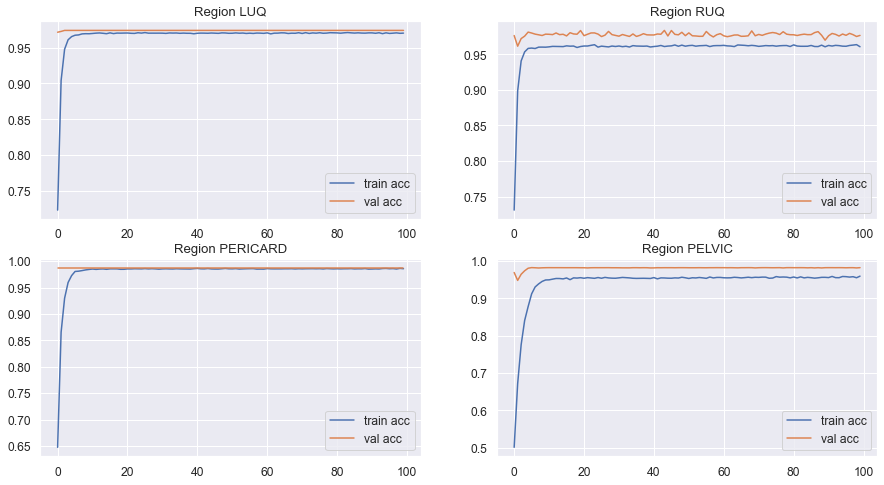

In [508]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    axs[i // 2, i % 2].plot(avg_reg_acc[reg]) 
    axs[i // 2, i % 2].plot(avg_reg_acc_val[reg])
    axs[i // 2, i % 2].set_title(f'Region {reg.name}')
    axs[i // 2, i % 2].legend(['train acc', 'val acc',], loc='best')
    
    
plt.show()
fib.savefig('./reg_avg_train.png', bbox_inches='tight', pad_inches=0)

In [501]:
avg_reg_loss = dict()
avg_reg_loss_val = dict()
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    avg = []
    val_avg = []
    for i in range(6):
        avg.append(fine_models_train_hist[i][reg]['loss'])
        val_avg.append(fine_models_train_hist[i][reg]['val_loss'])
    
    avg_reg_loss[reg] = np.mean(avg, axis=0)
    avg_reg_loss_val[reg] = np.mean(val_avg, axis=0)

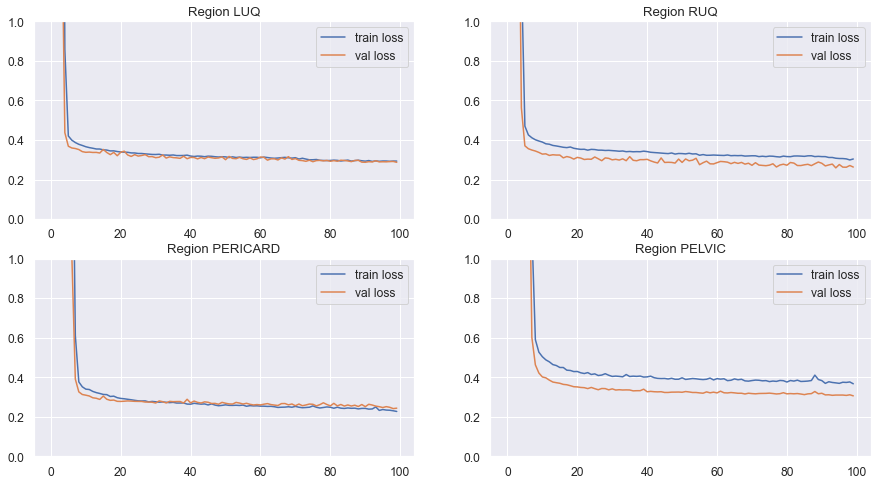

In [506]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    axs[i // 2, i % 2].plot(avg_reg_loss[reg]) 
    axs[i // 2, i % 2].plot(avg_reg_loss_val[reg])
    axs[i // 2, i % 2].set_title(f'Region {reg.name}')
    axs[i // 2, i % 2].set_ylim(0, 1, 0.001)
    axs[i // 2, i % 2].legend(['train loss', 'val loss',], loc='best')
    
    
plt.show()
fib.savefig('./reg_avg_train.png', bbox_inches='tight', pad_inches=0)

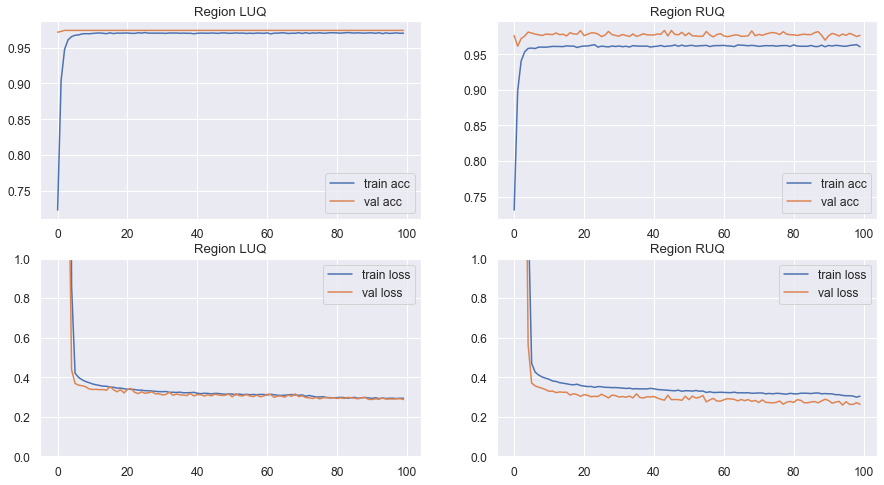

In [554]:
fib, axs = plt.subplots(2, 2, figsize=(15,8))

for i, reg in enumerate([Scan.LUQ, Scan.RUQ]):
    axs[0, i % 2].plot(avg_reg_acc[reg]) 
    axs[0, i % 2].plot(avg_reg_acc_val[reg])
    axs[0, i % 2].set_title(f'Region {reg.name}')
    axs[0, i % 2].legend(['train acc', 'val acc',], loc='best')

for i, reg in enumerate([Scan.LUQ, Scan.RUQ]):
    axs[1, i % 2].plot(avg_reg_loss[reg]) 
    axs[1, i % 2].plot(avg_reg_loss_val[reg])
    axs[1, i % 2].set_title(f'Region {reg.name}')
    axs[1, i % 2].set_ylim(0, 1, 0.001)
    axs[1, i % 2].legend(['train loss', 'val loss',], loc='best')
    
plt.show()


## Stats

In [87]:
from sklearn.metrics import classification_report

matrices = []
recall_cores = []

model = keras.models.load_model(f'best_model_{5}.tf')
train, valid, test = iterations[5]
train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_test, y_test = test
y_pred = model.predict(x_test)

y_test_cat = keras.utils.to_categorical(y_test)
y_test_cat = y_test_cat.argmax(axis=1)
y_pred = np.argmax(y_pred, axis=1)
target_names = ['Expert', 'Intermediate', 'Novice']
print(classification_report(y_test, y_pred, target_names=target_names))
"""
recall_cores.append(recall_score(y_test, y_pred, average="macro"))
matrices.append(confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0]))
res_perclass = score(y_test, y_pred,average=None,)

precision, recall, fscore, support = res_perclass
print(f'Model per class {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()

res = score(y_test, y_pred, average='macro')
precision, recall, fscore, support = res
print(f'Model avg {2}')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print()
"""
    
    

              precision    recall  f1-score   support

      Expert       0.00      0.00      0.00       717
Intermediate       0.83      0.79      0.81      8174
      Novice       0.82      0.89      0.86     12474

    accuracy                           0.83     21365
   macro avg       0.55      0.56      0.56     21365
weighted avg       0.80      0.83      0.81     21365



'\nrecall_cores.append(recall_score(y_test, y_pred, average="macro"))\nmatrices.append(confusion_matrix(y_test_cat,y_pred,labels=[2, 1, 0]))\nres_perclass = score(y_test, y_pred,average=None,)\n\nprecision, recall, fscore, support = res_perclass\nprint(f\'Model per class {2}\')\nprint(\'precision: {}\'.format(precision))\nprint(\'recall: {}\'.format(recall))\nprint(\'fscore: {}\'.format(fscore))\nprint(\'support: {}\'.format(support))\nprint()\n\nres = score(y_test, y_pred, average=\'macro\')\nprecision, recall, fscore, support = res\nprint(f\'Model avg {2}\')\nprint(\'precision: {}\'.format(precision))\nprint(\'recall: {}\'.format(recall))\nprint(\'fscore: {}\'.format(fscore))\nprint(\'support: {}\'.format(support))\nprint()\n'

In [81]:
conf_matrices = []
recalls = []
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import recall_score, f1_score
for i in range(6):
    model = keras.models.load_model(f'best_model_{i}.tf')
    train, valid, test = iterations[i]
    train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
    train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

    x_test, y_test = test
    y_pred = model.predict(x_test)
    
    y_test_cat = keras.utils.to_categorical(y_test)
    y_test_cat = y_test_cat.argmax(axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    precision, recall, fscore, support = score(y_test, y_pred)
    conf_matrices.append(confusion_matrix(y_test_cat, y_pred, labels=[2, 1, 0]))
    print(f'Model {i + 1}')
    recalls.append(recall)
    print('recall: {}'.format(recall))
    print()


Model 1
recall: [0.         0.91200963 0.9015198 ]



/Users/dorn_kern/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 2
recall: [0.         0.91141041 0.94935432]

Model 3
recall: [0.         0.91843082 0.77523342]

Model 4
recall: [0.         0.81061904 0.92263909]

Model 5
recall: [0.         0.88096035 0.87711864]

Model 6
recall: [0.         0.79153413 0.89474106]



In [76]:
np.sum(conf_matrices, axis=0)

array([[74429,  9166,   435],
       [ 7424, 52766,     0],
       [ 2528,   930,     0]])

In [52]:
np.mean(recalls, axis=0)

array([0.        , 0.94004258, 0.91824765])

<ipython-input-55-960e9efc0813>:5: RuntimeWarning: invalid value encountered in true_divide
  normalized = summed / np.sum(summed, axis=0)


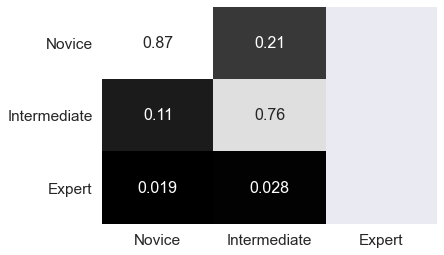

In [55]:
#true (rows), predicted (columns) 
import seaborn as sn
import pandas as pd
labels = ["Novice", "Intermediate", "Expert"]
normalized = summed / np.sum(summed, axis=0)
df_cm = pd.DataFrame(normalized, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray") # font size

plt.show()

In [46]:
recall_cores

[0.8559607869260147,
 0.7645052061667065,
 0.6609185856399599,
 0.6445271908555594,
 0.7323232323232324,
 0.6663202863410692]

In [47]:
recall_cores

[0.8559607869260147,
 0.7645052061667065,
 0.6609185856399599,
 0.6445271908555594,
 0.7323232323232324,
 0.6663202863410692]

In [48]:
np.mean(recall_cores)

0.720759214708757

In [183]:
np.mean([0.779, 0.853, 0.790, 0.725])

0.7867500000000001

## stats for regions

In [194]:
from sklearn.metrics import precision_recall_fscore_support as score

regions_stats = dict()


for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'REGION: {reg}')
    regions_stats[reg] = dict()
    regions_acc = []
    for stat in ['recall']:
        regions_stats[reg][stat] = []
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        model = keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf')
        train, valid, test = iterations[i]
        train, valid, test = folds_all[train], folds_all[valid], folds_all[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_test, y_test = test
        loss, acc = model.evaluate(x_test, y_test)
        regions_acc.append(acc)
        y_pred = model.predict(x_test)

        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        precision, recall, fscore, support = score(y_test, y_pred)

        print(f'Fold {i + 1}')
        #print('precision: {}'.format(precision))
        #regions_stats[reg]['precision'].append(precision)
        print('recall: {}'.format(recall))
        regions_stats[reg]['recall'].append(recall)
        #print('fscore: {}'.format(fscore))
        #regions_stats[reg]['fscore'].append(fscore)
        #print('support: {}'.format(support))
    
    print(f'{reg} acc: {np.mean(regions_acc, axis=0)}')
    
    print('='*20)


REGION: Scan.LUQ
787/787 [==============================] - 2s 2ms/step - loss: 0.5906 - sparse_categorical_accuracy: 0.8792
Fold 1
recall: [0.         0.87729507 0.91201527]
854/854 [==============================] - 2s 2ms/step - loss: 0.4654 - sparse_categorical_accuracy: 0.9278
Fold 2
recall: [0.         0.91509118 0.96838849]
787/787 [==============================] - 2s 2ms/step - loss: 0.9188 - sparse_categorical_accuracy: 0.7885
Fold 3
recall: [0.         0.94040333 0.71355551]
668/668 [==============================] - 2s 2ms/step - loss: 0.6774 - sparse_categorical_accuracy: 0.8758
Fold 4
recall: [0.         0.92317103 0.8951419 ]
854/854 [==============================] - 2s 2ms/step - loss: 0.8864 - sparse_categorical_accuracy: 0.8322
Fold 5
recall: [0.         0.97348168 0.74576271]
668/668 [==============================] - 1s 2ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.8777
Fold 6
recall: [0.         0.94861757 0.88175405]
Scan.LUQ acc: 0.8635420898596445
RE

In [198]:
regions_stats

{<Scan.LUQ: 'Scan01'>: {'recall': [array([0.        , 0.87729507, 0.91201527]),
   array([0.        , 0.91509118, 0.96838849]),
   array([0.        , 0.94040333, 0.71355551]),
   array([0.        , 0.92317103, 0.8951419 ]),
   array([0.        , 0.97348168, 0.74576271]),
   array([0.        , 0.94861757, 0.88175405])]},
 <Scan.RUQ: 'Scan02'>: {'recall': [array([0.        , 0.91652453, 0.9330062 ]),
   array([0.        , 0.91550945, 0.92298897]),
   array([0.        , 0.98996689, 0.53186124]),
   array([0.        , 0.98568632, 0.72534873]),
   array([0.        , 0.98494228, 0.75134517]),
   array([0.        , 0.98005872, 0.80711881])]},
 <Scan.PERICARD: 'Scan03'>: {'recall': [array([0.        , 0.90598977, 0.89313705]),
   array([0.77983539, 0.85402376, 0.92924401]),
   array([0.        , 0.98695696, 0.62304914]),
   array([0.        , 0.98898948, 0.72518839]),
   array([0.        , 0.98402208, 0.86225451]),
   array([0.        , 0.98519697, 0.7046657 ])]},
 <Scan.PELVIC: 'Scan04'>: {'r

In [196]:
averaged_stats = dict()

for reg in regions_stats:
    averaged_stats[reg] = dict()
    
    for stat in regions_stats[reg]:
        averaged_stats[reg][stat] = np.mean(np.array(regions_stats[reg][stat]), axis=0)

In [199]:
averaged_stats

{<Scan.LUQ: 'Scan01'>: {'recall': array([0.        , 0.92967664, 0.85276965])},
 <Scan.RUQ: 'Scan02'>: {'recall': array([0.        , 0.9621147 , 0.77861152])},
 <Scan.PERICARD: 'Scan03'>: {'recall': array([0.12997257, 0.95086317, 0.7895898 ])},
 <Scan.PELVIC: 'Scan04'>: {'recall': array([0.4464512 , 0.78226613, 0.72492696])}}

In [200]:
for reg in averaged_stats:
    print(f'{reg} {stat}: {averaged_stats[reg]["recall"]}')


Scan.LUQ recall: [0.         0.92967664 0.85276965]
Scan.RUQ recall: [0.         0.9621147  0.77861152]
Scan.PERICARD recall: [0.12997257 0.95086317 0.7895898 ]
Scan.PELVIC recall: [0.4464512  0.78226613 0.72492696]


In [211]:
np.mean([0.871, 0.892, 0.813, 0.754])

0.8324999999999999

## best model test

In [67]:
acc_dict = dict()
recall_dict = dict()
reg_confusions = dict()

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    acc_dict[reg] = []
    recall_dict[reg] = []
    reg_confusions[reg] = []

for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    print(f'REGION: {reg}')
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        model = keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf')

        x_test, y_test = test
        y_pred = model.predict(x_test)

        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        
        acc_dict[reg].append(model.evaluate(x_test, y_test)[1])
        y_pred = model.predict(x_test)
        
        y_test_cat = keras.utils.to_categorical(y_test)
        y_test_cat = y_test_cat.argmax(axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        res_perclass = score(y_test, y_pred, average=None,)
        precision, recall, fscore, support = res_perclass

        recall_dict[reg].append(recall)
        reg_confusions[reg].append(confusion_matrix(y_test_cat, y_pred, normalize='true', labels=[2, 1, 0]))

REGION: Scan.LUQ
208/208 [==============================] - 1s 3ms/step - loss: 0.7985 - sparse_categorical_accuracy: 0.9553
REGION: Scan.RUQ
189/189 [==============================] - 1s 4ms/step - loss: 2.2795 - sparse_categorical_accuracy: 0.7601
REGION: Scan.PERICARD
90/90 [==============================] - 1s 3ms/step - loss: 0.7698 - sparse_categorical_accuracy: 0.9649
REGION: Scan.PELVIC
117/117 [==============================] - 1s 3ms/step - loss: 1.3064 - sparse_categorical_accuracy: 0.8852


In [68]:
reg_mean= []
for key in acc_dict:
    print(f'{key} Expert | Intermed | Nov')
    
    print(np.mean(np.array(recall_dict[key]), axis=0))


Scan.LUQ Expert | Intermed | Nov
[0.         0.98848211 0.96922409]
Scan.RUQ Expert | Intermed | Nov
[0.         0.8378333  0.71390918]
Scan.PERICARD Expert | Intermed | Nov
[0.         0.9436614  0.95889076]
Scan.PELVIC Expert | Intermed | Nov
[0.         0.74052628 0.92500005]


In [69]:
reg_mean= []
for key in acc_dict:
    reg_mean.append(np.mean(acc_dict[key]))
    print(f'{key} {reg_mean[-1]}')

print(f'All mean {np.mean(reg_mean)}')


Scan.LUQ 0.9505850176016489
Scan.RUQ 0.7806001007556915
Scan.PERICARD 0.9442786773045858
Scan.PELVIC 0.8422380288441976
All mean 0.879425456126531


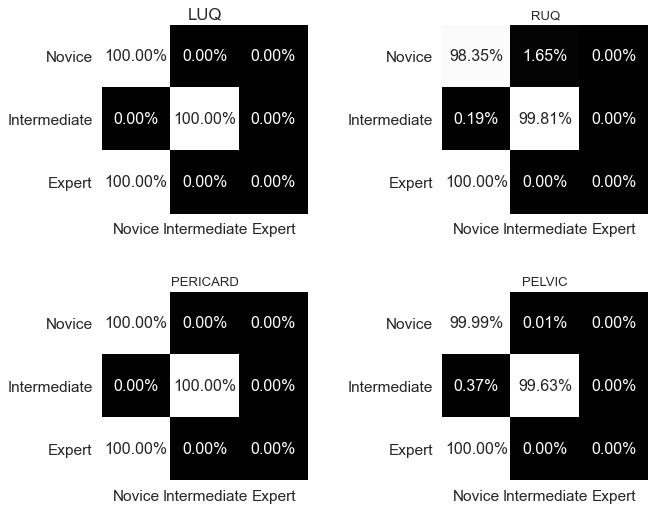

In [400]:
import seaborn as sn
import pandas as pd

fig, axs = plt.subplots(2, 2, figsize=(10,8))
reg_mean_conf= []
for i, key in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    #true (rows), predicted (columns) 
    ax = axs[i // 2, i % 2]
    ax.set_title(key.name)
    labels = ["Novice", "Intermediate", "Expert"]
    normalized = np.mean(reg_confusions[key], axis=(0))
    df_cm = pd.DataFrame(normalized, range(3), range(3))
    sn.set(font_scale=1.1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},  
               yticklabels=labels, 
                xticklabels=labels, 
               cbar=False, cmap='gray',
                ax=ax,  fmt=".2%") # font size
    
fig.tight_layout(pad=3.0)
plt.show()





[[0.99584764 0.00415236 0.        ]
 [0.00138212 0.99861788 0.        ]
 [1.         0.         0.        ]]


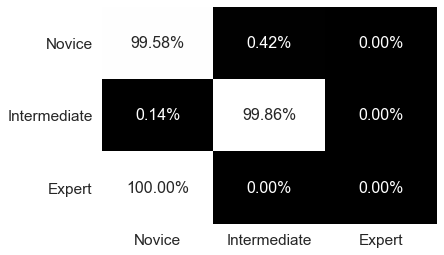

In [399]:
reg_mean_conf= []
for key in reg_confusions:
    reg_mean_conf.append(np.mean(reg_confusions[key], axis=(0)))

all_conf = np.mean(reg_mean_conf, axis=0)
print(all_conf)
df_cm = pd.DataFrame(all_conf, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray",  fmt=".2%") # font size

plt.show()

In [277]:
recall_cores = []
i = 1
reg = Scan.ALL
novices_reg, intermed_reg, experts_reg = prepared[reg]
folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)

train, valid, test = iterations[i]
train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

x_train, y_train = train
x_val, y_val = valid
x_test, y_test = test

model = keras.models.load_model(f'best_model_{i}.tf')
acc = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
print(f'REg {reg} acc: {acc[1]:.4f}')
y_test_cat = y_test
# y_test_cat = keras.utils.to_categorical(y_test)
# y_test_cat = np.argmax(y_test_cat, axis=1)
y_pred = np.argmax(y_pred, axis=1)

recall_cores.append(recall_score(y_test, y_pred, average="macro"))
all_confusion_matrix = confusion_matrix(y_test_cat, y_pred,labels=[2, 1, 0])
print(all_confusion_matrix)
res_perclass = score(y_test, y_pred,average=None,)

precision, recall, fscore, support = res_perclass
print(f'Model per class {2} Region: {reg}')
print(f'recall: {recall}')
print(f'recall: {support}')
plt.show()

775/775 [==============================] - 1s 1ms/step - loss: 0.2838 - sparse_categorical_accuracy: 0.9711
REg Scan.ALL acc: 0.9711
[[13963     0     0]
 [    0 10097     0]
 [  717     0     0]]
Model per class 2 Region: Scan.ALL
recall: [0. 1. 1.]
recall: [  717 10097 13963]


In [ ]:
#true (rows), predicted (columns) 
import seaborn as sn
import pandas as pd
labels = ["Novice", "Intermediate", "Expert"]
normalized = summed / np.sum(summed, axis=0)
df_cm = pd.DataFrame(normalized, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, 
           xticklabels=labels, 
           yticklabels=labels, 
           cbar=False, cmap="gray") # font size

plt.show()

In [401]:
[ProficiencyLabel.Novice]*5

[<ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>,
 <ProficiencyLabel.Novice: 2>]

## voting for model 2


In [467]:
i = 1
reg = Scan.ALL
model = keras.models.load_model(f'best_model_{i}.tf')

novices_reg, intermed_reg, experts_reg = prepared[reg]
folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)

train, valid, test = iterations[i]
train, valid, test_reg = folds_reg[train], folds_reg[valid], folds_reg[test]
test_nov = test_reg[0]

test_classes = [ProficiencyLabel.Novice]*5 #+ [ProficiencyLabel.Intermediate]*4 + [ProficiencyLabel.Expert]
for i, true_label in zip(range(5), test_classes):
    test_sliced_x, test_sliced_y = ut.data_slicing(np.array([test_nov[i]]), slice_window, true_label)
    y_pred = model.predict(np.array(test_sliced_x))
    y_pred = np.argmax(y_pred, axis=1)
    counts = np.bincount(y_pred)
    print(f'Class {ProficiencyLabel(np.argmax(counts)).name}, true class: {true_label}')

test_inter = test_reg[1]
test_classes = [ProficiencyLabel.Intermediate]*5 #+ [ProficiencyLabel.Expert]
for i, true_label in zip(range(5), test_classes):
    test_sliced_x, test_sliced_y = ut.data_slicing(np.array([test_inter[i]]), slice_window, true_label)
    y_pred = model.predict(np.array(test_sliced_x))
    y_pred = np.argmax(y_pred, axis=1)
    counts = np.bincount(y_pred)
    print(f'Class {ProficiencyLabel(np.argmax(counts)).name}, true class: {true_label}')
    
test_exp = test_reg[2]
test_classes = [ProficiencyLabel.Expert]
for i, true_label in zip(range(1), test_classes):
    test_sliced_x, test_sliced_y = ut.data_slicing(np.array([test_exp[i]]), slice_window, true_label)
    y_pred = model.predict(np.array(test_sliced_x))
    y_pred = np.argmax(y_pred, axis=1)
    counts = np.bincount(y_pred)
    print(f'Class {ProficiencyLabel(np.argmax(counts)).name}, true class: {true_label}')

Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Novice, true class: ProficiencyLabel.Novice
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Intermediate, true class: ProficiencyLabel.Intermediate
Class Novice, true class: ProficiencyLabel.Expert


In [470]:
iterations

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [106]:
def consensus_all(fold_pair, true_label, part, reg=Scan.ALL, verbose=False):
    models = []
    votes = []
    for i in fold_pair:
        models.append(keras.models.load_model(f'best_model_{i}.tf'))
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    
    train, valid, test = iterations[fold_pair[0]]
    train, valid, test_reg = folds_reg[train], folds_reg[valid], folds_reg[test]
    samples = test_reg[part]
    
    test_classes = [true_label]*len(samples)
    for i, true_label in zip(range(len(samples)), test_classes):
        test_sliced_x, test_sliced_y = ut.data_slicing(np.array([samples[i]]), slice_window, true_label)
        
        for m in models:
            y_pred = m.predict(np.array(test_sliced_x))
            y_pred = np.argmax(y_pred, axis=1)
            counts = np.bincount(y_pred)

            model_vote = ProficiencyLabel(np.argmax(counts))
            if verbose:
                print(f'Class {model_vote.name}, true class: {true_label}')
            votes.append((model_vote, true_label))
    
    return votes

In [132]:
def consensus(reg, fold_pair, true_label, part, verbose=False):
    models = []
    votes = []
    for i in fold_pair:
        models.append(keras.models.load_model(f'best_model_tuned_{i}_{reg}.tf'))
    
    novices_reg, intermed_reg, experts_reg = prepared[reg]
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    
    train, valid, test = iterations[fold_pair[0]]
    train, valid, test_reg = folds_reg[train], folds_reg[valid], folds_reg[test]
    samples = test_reg[part]
    
    test_classes = [true_label]*len(samples)
    for i, true_label in zip(range(len(samples)), test_classes):
        test_sliced_x, test_sliced_y = ut.data_slicing(np.array([samples[i]]), slice_window, true_label)
        
        for m in models:
            y_pred = m.predict(np.array(test_sliced_x))
            y_pred = np.argmax(y_pred, axis=1)
            counts = np.bincount(y_pred)

            model_vote = ProficiencyLabel(np.argmax(counts))
            if verbose:
                print(f'Class {model_vote.name}, true class: {true_label}')
            votes.append((model_vote, true_label))
    
    return votes

In [108]:
def count_consensus(votes, true_label):
    stats = dict()
    
    for l in [ProficiencyLabel.Novice, ProficiencyLabel.Intermediate, ProficiencyLabel.Expert]:
        stats[l] = 0
    
    for v in votes:
        stats[v[0]] += 1
    
    
    print(f'True label: {true_label}')
    for k in stats:
        print(f'{k}: {stats[k]}')
    
    return stats

In [110]:
for true_lab in [ProficiencyLabel.Novice, ProficiencyLabel.Intermediate, ProficiencyLabel.Expert]:
    fold_pairs = [(0, 2), (1, 4), (3, 5)]
    part = np.abs(true_lab.value - 2) # 0 - N, 1 - I, 2 - E
    f1 = consensus_all(fold_pairs[0], true_lab, part)
    f2 = consensus_all(fold_pairs[1], true_lab, part)
    f3 = consensus_all(fold_pairs[2], true_lab, part)
    stats = count_consensus(f1+f2+f3, true_lab)


True label: ProficiencyLabel.Novice
ProficiencyLabel.Novice: 28
ProficiencyLabel.Intermediate: 0
ProficiencyLabel.Expert: 0
True label: ProficiencyLabel.Intermediate
ProficiencyLabel.Novice: 1
ProficiencyLabel.Intermediate: 29
ProficiencyLabel.Expert: 0
True label: ProficiencyLabel.Expert
ProficiencyLabel.Novice: 5
ProficiencyLabel.Intermediate: 1
ProficiencyLabel.Expert: 0


In [133]:
## conf_stats = dict()

for reg in [Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]:
    fold_pairs = [(0, 2), (1, 4), (3, 5)]
    for true_lab in [ProficiencyLabel.Novice, ProficiencyLabel.Intermediate, ProficiencyLabel.Expert]:
        part = np.abs(true_lab.value - 2) # 0 - N, 1 - I, 2 - E
        print(f'{true_lab} for {reg}')
        f1 = consensus(reg, fold_pairs[0], true_lab, part)
        f2 = consensus(reg, fold_pairs[1], true_lab, part)
        f3 = consensus(reg, fold_pairs[2], true_lab, part)
        count_consensus(f1+f2+f3, true_lab)
        print()
    print()


ProficiencyLabel.Novice for Scan.LUQ
True label: ProficiencyLabel.Novice
ProficiencyLabel.Novice: 28
ProficiencyLabel.Intermediate: 0
ProficiencyLabel.Expert: 0

ProficiencyLabel.Intermediate for Scan.LUQ
True label: ProficiencyLabel.Intermediate
ProficiencyLabel.Novice: 2
ProficiencyLabel.Intermediate: 28
ProficiencyLabel.Expert: 0

ProficiencyLabel.Expert for Scan.LUQ
True label: ProficiencyLabel.Expert
ProficiencyLabel.Novice: 6
ProficiencyLabel.Intermediate: 0
ProficiencyLabel.Expert: 0


ProficiencyLabel.Novice for Scan.RUQ
True label: ProficiencyLabel.Novice
ProficiencyLabel.Novice: 19
ProficiencyLabel.Intermediate: 9
ProficiencyLabel.Expert: 0

ProficiencyLabel.Intermediate for Scan.RUQ
True label: ProficiencyLabel.Intermediate
ProficiencyLabel.Novice: 1
ProficiencyLabel.Intermediate: 29
ProficiencyLabel.Expert: 0

ProficiencyLabel.Expert for Scan.RUQ
True label: ProficiencyLabel.Expert
ProficiencyLabel.Novice: 0
ProficiencyLabel.Intermediate: 6
ProficiencyLabel.Expert: 0


Prof

True label: ProficiencyLabel.Expert
ProficiencyLabel.Novice: 3
ProficiencyLabel.Intermediate: 1
ProficiencyLabel.Expert: 2


